# **PPP (and Climatology)**

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import math
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid

from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import cmocean.cm as cmo

from PIL import Image

%load_ext autoreload
%autoreload 2
import hmei.processing as pcs
import hmei.visualization as vis

# Compute PPP

$$ PPP(t) = 1 - \frac{\frac{1}{N(M - 1)} \sum\limits_{j=1}^{N} \sum\limits_{I=1}^{M} (X_{ij}(t) - \overline{X}_{j}(t))^{2}}{\sigma_{c}^{2}} $$

"where $X_{ij}(t)$ is the value of a given variable for the $j$th ensemble and $i$th ensemble member, $\overline{X}_{j}$ is the mean of the $j$th ensemble over all ensemble members, $\sigma_{c}^{2}$ is the variance of the control simulation, $N$ is the total number of different ensemble simulations ($N$=6) and $M$ the number of ensemble members ($M$=40)" - Froelicher et al. 2020

In [2]:
# pcs.dir_inspect('/local/projects/so_predict/esm2m_froelicher/SST_ENSEMBLE')

In [3]:
def comp_ppp(var, reg, save=False, timescale='monthly'):

    ## import necessary data
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    
    ## variance of the control simulation for each month
    ## dimensions (month: 12)
    subdir = 'CTRL/'+var.upper()+'/'
    filename = var.lower()+'_ts_'+reg+'_'+timescale+'_var.nc'
    ctrl_var = xr.open_dataset(writedir+subdir+filename)
    
    ## ensemble anomalies
    ## dimensions (nStart: 6, nEns: 40, nT: 120)
    subdir = var.upper()+'_ENSEMBLE/'
    filename = var.lower()+'_ens_'+reg+'_'+timescale+'_anom.nc'
    ens_anom = xr.open_dataset(writedir+subdir+filename)
    
    regions = ctrl_var.data_vars

    ## constants
    N = 6
    M = 40

    ## numerator coefficient
    num_coeff = 1 / (N * (M - 1))

    ## numerator outer sum - across all ensembles
    num_outer_sum = np.zeros((6,120))

    PPP = np.zeros( (len(regions), 120) )

    for (iReg,r) in zip(range(len(regions)), regions):

        for j in range(N):
            ## numerator inner sum - across all ensemble members
            num_inner_sum = np.zeros((40,120))

            ## ensemble mean
            ens_mean = ens_anom[r][j].mean(dim='nEns')

            for i in range(M):
                num_inner_sum[i] = np.square(ens_anom[r][j,i] - ens_mean)

            num_outer_sum[j] = np.sum(num_inner_sum, axis=0)

        ## numerator total sum
        num_sum = np.sum(num_outer_sum, axis=0)

        ## compute PPP
        for m in range(120):
            PPP[iReg][m] = 1 - ( (num_coeff * num_sum[m]) / ctrl_var[r][m%12] )
            
    ## organize PPP data in a Dataset
    PPP_da = []
    for (iReg,r) in zip(range(len(regions)), regions):
        
        PPP_reg = xr.DataArray(
                    data=PPP[iReg],
                    dims=['nT'],
                    coords=dict(
                        nT=np.arange(1,121)
                    ),
                    name=r
                )
        
        PPP_da.append(PPP_reg.copy(deep=True))
    
    PPP_ds = xr.merge(PPP_da)
    PPP_ds.attrs['name'] = var.lower()+'_ts_'+reg+'_'+timescale+'_ppp.nc'
        
    if save:
        subdir = 'PPP/'+var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_ppp.nc'
        PPP_ds.to_netcdf(writedir+subdir+filename)
        print(writedir+subdir+filename)
        
    elif not save:
        return PPP_ds

## PPP Seasonal Cycle
Average each month's PPP and plot 12-month seasonal cycle of PPP for each metric.

In [2]:
def comp_ppp_szncycle(var, reg, save=False):
    ppp = open_ppp(var, reg, timescale='monthly')
    num_vars = len(ppp.data_vars)
    
    month_vals = np.zeros((num_vars,12,10))
    
    for (i,r) in zip(range(num_vars), ppp.data_vars):
        for m in range(len(ppp['nT'])):
            month_vals[i,m%12,int(m/12)] = ppp[r][m]
            
    np_ppp_cycle = month_vals.mean(axis=2)
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                   'August', 'September', 'October', 'November', 'December']
    abbrv_month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                         'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    ppp_cycle = ppp.copy(deep=True)
    ppp_cycle = ppp_cycle.drop('nT')
    ppp_cycle = ppp_cycle.assign_coords({'month':month_names})
    ppp_cycle = ppp_cycle.assign_coords({'abbrv_month':abbrv_month_names})
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir = 'PPP/'+var.upper()+'/'
    filename = var.lower()+'_ts_'+reg.lower()+'_szncycle_ppp.nc'
    ppp_cycle.attrs['name'] = filename
    
    for (i,r) in zip(range(num_vars), ppp_cycle.data_vars):
        ppp_cycle[r] = (('month'), np_ppp_cycle[i])
    
    if save:
        ppp_cycle.to_netcdf(writedir+subdir+filename)
        print(writedir+subdir+filename)
        
    if not save:
        print('not saved - '+writedir+subdir+filename)
        return ppp_cycle

In [3]:
variables = ['sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr']
regions = ['global', 'so']

# for var in variables:
#     for reg in regions:
#         comp_ppp_szncycle(var, reg, save=True)

# Compute Climatology
Compute the climatology for each metric over the 300-year control simulation to use when interpreting the PPP figures.

In [4]:
def comp_clim(var, reg, save=False): 
    writedir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    subdir = var.upper()+'/'
    filename = var.lower()+'_ts_'+reg+'_monthly_mean.nc'
    
    monthly_mean = xr.open_dataset(writedir+subdir+filename)
    clim = monthly_mean.groupby('time.month').mean(dim='time')
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                   'August', 'September', 'October', 'November', 'December']
    abbrv_month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                         'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    clim['month'] = month_names
    clim['abbrv_month'] = abbrv_month_names
    
    filename = var.lower()+'_ts_'+reg+'_clim.nc'
    clim.attrs['name'] = filename
    
    if save:
        clim.to_netcdf(writedir+subdir+filename)
        print(writedir+subdir+filename)
    if not save:
        print('not saved - '+writedir+subdir+filename)
        return clim
    

In [5]:
variables = ['sst', 'sss', 'npp', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv']
regions = ['global', 'so']

# for var in variables:
#     for reg in regions:
#         comp_clim(var, reg, save=True)

# Compute Monthly Std Dev

In [6]:
def comp_std(var, reg, save=False): 
    writedir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    subdir = var.upper()+'/'
    filename = var.lower()+'_ts_'+reg+'_monthly_mean.nc'
    
    monthly_mean = xr.open_dataset(writedir+subdir+filename)
    std = monthly_mean.groupby('time.month').std(dim='time')
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                   'August', 'September', 'October', 'November', 'December']
    abbrv_month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                         'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    std['month'] = month_names
    std['abbrv_month'] = abbrv_month_names
    
    filename = var.lower()+'_ts_'+reg+'_std.nc'
    std.attrs['name'] = filename
    
    if save:
        std.to_netcdf(writedir+subdir+filename)
        print(writedir+subdir+filename)
    if not save:
        print('not saved - '+writedir+subdir+filename)
        return std
    

In [7]:
# variables = ['sst', 'sss', 'npp', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv']
variables = ['sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr']
regions = ['global', 'so']

# for var in variables:
#     for reg in regions:
#         comp_std(var, reg, save=True)

# Plotting Functions

~~All of the following functions should now be part of the `hmei.visualization` package.~~

In [8]:
reg_colors = dict({'Global':'black', 'SouthernOcean':'black', 'Weddell':'red', 'Indian':'blue', 'WestPacific':'green', 'Ross':'orange', 'AmundBell':'magenta'})
    
var_colors = dict({'npp':'limegreen', 'mld':'black', 'sie':'blue', 'sst':'red', 'sss':'darkorange', 'cn_inv':'deepskyblue', 'pco2surf':'magenta',
                   'siv':'darkslateblue', 'sfc_fed':'darkgoldenrod', 'sfc_irr':'firebrick', 'sfc_biomass':'forestgreen', 
                   'sfc_chl':'mediumseagreen'})

reg_names = dict({'Global':'Global', 'SouthernOcean':'Pan-Antarctic', 'Weddell':'Weddell', 'Indian':'Indian', 'WestPacific':'West Pacific', 'Ross':'Ross', 
                  'AmundBell':'A and B'})

var_su_names = dict({'npp':'NPP', 'mld':'MLD', 'sie':'SIE', 'sst':'SST', 'sss':'SSS', 'cn_inv':'SIC', 'pco2surf':'Surface pCO$_2$', 'siv':'SIV',
                     'sfc_fed':'SFC_FED', 'sfc_irr':'SFC_IRR', 'sfc_biomass':'SFC_BIOMASS', 'sfc_chl':'SFC_CHL'})

var_lu_names = dict({'npp':'Net Primary Production', 'mld':'Mixed Layer Depth', 'sie':'Sea Ice Extent', 'sst':'Sea Surface Temperature', 
                     'sss':'Sea Surface Salinity', 'cn_inv':'Sea Ice Concentration', 'pco2surf':'Surface pCO$_2$', 'siv':'Sea Ice Volume',
                     'sfc_fed':'Surface Dissolved Iron', 'sfc_irr':'Surface Irradiance', 'sfc_biomass':'Surface Biomass N', 
                     'sfc_chl':'Surface Chl'})

var_ll_names = dict({'npp':'Net primary production', 'mld':'Mixed layer depth', 'sie':'Sea ice extent', 'sst':'Sea surface temperature', 
                     'sss':'Sea surface salinity', 'cn_inv':'Sea ice concentration', 'pco2surf':'Surface pCO$_2$', 'siv':'Sea ice volume',
                     'sfc_fed':'Surface dissolved iron', 'sfc_irr':'Surface irradiance', 'sfc_biomass':'Surface biomass N', 
                     'sfc_chl':'Surface Chl'})

ltx_units = dict({'npp':'mol C m$^{-2}$ s$^{-1}$', 'mld':'m', 'sie':'m$^2$', 'sst':'$^\circ$C', 'sss':'psu', 'cn_inv':'%', 'pco2surf':'uatm',
                  'siv':'m$^3$', 'sfc_fed':'mol kg$^{-1}$', 'sfc_irr':'W m$^{-2}$', 'sfc_biomass':'mol kg$^{-1}$', 'sfc_chl':'ug kg$^{-1}$'})

uni_units = dict({'npp':'mol C m^-2 s^-1', 'mld':'m', 'sie':'m^2', 'sst':'degC', 'sss':'psu', 'cn_inv':'%', 'pco2surf':'uatm',
                  'siv':'m^3', 'sfc_fed':'mol kg^-1', 'sfc_irr':'W m^-2', 'sfc_biomass':'mol kg^-1', 'sfc_chl':'ug kg^-1'})

ltx_var_units = dict({'npp':'(mol C m$^{-2}$ s$^{-1}$)$^{2}$', 'mld':'m$^{2}$', 'sie':'(m$^2$)$^{2}$', 'sst':'($^\circ$C)$^{2}$', 'sss':'psu$^{2}$', 
                      'cn_inv':'%$^{2}$', 'pco2surf':'uatm$^{2}$', 'siv':'(m$^3$)$^{2}$', 'sfc_fed':'(mol kg$^{-1}$)$^{2}$', 
                      'sfc_irr':'(W m$^{-2}$)$^{2}$', 'sfc_biomass':'(mol kg$^{-1}$)$^{2}$', 'sfc_chl':'(ug kg$^{-1}$)$^{2}$'})

uni_var_units = dict({'npp':'(mol C m^-2 s^-1)^2', 'mld':'m^2', 'sie':'(m^2)^2', 'sst':'(degC)^2', 'sss':'psu^2', 'cn_inv':'%^2', 'pco2surf':'uatm^2',
                      'siv':'(m^3)^2', 'sfc_fed':'(mol kg^-1)^2', 'sfc_irr':'(W m^-2)^2', 'sfc_biomass':'(mol kg^-1)^2', 'sfc_chl':'(ug kg^-1)^2'})

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

abbrv_month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plotting_dicts = dict({'reg_colors':reg_colors, 'var_colors':var_colors, 'reg_names':reg_names, 'var_su_names':var_su_names, 
                        'var_lu_names':var_lu_names, 'var_ll_names':var_ll_names, 'ltx_units':ltx_units, 'uni_units':uni_units, 
                         'ltx_var_units':ltx_var_units, 'uni_var_units':uni_var_units, 'month_names':month_names, 'abbrv_month_names':abbrv_month_names})

# filehandler = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl', 'wb')
# pkl.dump(plotting_dicts, filehandler)
# filehandler.close()

In [9]:
# infile = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
# d = pkl.load(infile)
# infile.close()

## Climatology

In [10]:
def plot_clim(
    var, reg, so_reg='SouthernOcean', leg_loc='outside', figsize=(10,5)):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    
    fig,ax = plt.subplots(figsize=figsize)
    month_ticks = np.arange(1,13)
    var = var.lower()
    ls = '-'
    
    if type(var) == list:
        assert len(var) <= 2, '\'var\' length is too long'
    
    if type(var) == str and type(so_reg) == str and so_reg != 'all':
        subdir = var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_clim.nc'
        ds = xr.open_dataset(writedir+subdir+filename)
        
        if var == 'cn_inv':
            ds = ds*100
        
        if reg == 'global':
            clim = ds['Global']
            title = 'Global '+var_lu_names[var]+' Climatology'
        if reg == 'so':
            clim = ds[so_reg]
            title = reg_names[so_reg]+' '+var_lu_names[var]+' Climatology'
            if so_reg == 'SouthernOcean':
                    ls = '-.'
            else:
                ls = '-'
            
        ax.plot(month_ticks, clim, color=var_colors[var], ls=ls)
        
        ax.set_title(title)
        ax.set_ylabel(var_su_names[var]+' ('+ltx_units[var]+')')
    
    if type(var) == list and type(so_reg) == str:
        for v in var:
            subdir = v.upper()+'/'
            filename = v.lower()+'_ts_'+reg+'_clim.nc'
            ds = xr.open_dataset(writedir+subdir+filename)
            
            if v == 'cn_inv':
                ds = ds*100
            
            if reg == 'global':
                clim = ds['Global']
            if reg == 'so':
                clim = ds[so_reg]
                if so_reg == 'SouthernOcean':
                    ls = '-.'
                else:
                    ls = '-'
            
            if var.index(v) == 0:
                ax.plot(month_ticks, clim, color=var_colors[v], label=var_su_names[v], ls=ls)
                ax.set_ylabel(var_su_names[v]+' ('+var_units[v]+')')
            
            if var.index(v) == 1:
                twinax = ax.twinx()
                twinax.plot(month_ticks, clim, color=var_colors[v], label=var_su_names[v], ls=ls)
                twinax.set_ylabel(var_su_names[v]+' ('+ltx_units[v]+')')
            
        ax.set_title(reg_names[so_reg]+' Climatology')        
        ax.legend(bbox_to_anchor = (1.04,1))
        twinax.legend(bbox_to_anchor = (1.15,0.91))
        
    if (type(so_reg) == list or so_reg == 'all') and type(var) == str:
        subdir = var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_clim.nc'
        ds = xr.open_dataset(writedir+subdir+filename)
        
        if var == 'cn_inv':
            ds = ds*100
        
        if so_reg == 'all':
            so_reg = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']
        
        for r in so_reg:
            clim = ds[r]
            if r == 'SouthernOcean':
                    ls = '-.'
            else:
                ls = '-'
            ax.plot(month_ticks, clim, color=reg_colors[r], label=reg_names[r], ls=ls)
            
        if leg_loc == 'outside':
            leg = ax.legend(bbox_to_anchor = (1.02,1))
        if leg_loc != 'outside':
            leg = ax.legend(loc=leg_loc)
        for line in leg.get_lines():
            line.set_linewidth(2.0)
            line.set_linestyle(line.get_linestyle())
            
        ax.set_title(var_lu_names[var]+' Climatology')
        ax.set_ylabel(var_su_names[var]+' ('+ltx_units[var]+')')
            
    ax.set_xticks(month_ticks)
    ax.set_xticklabels(ds['abbrv_month'].values)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    ax.set_xlim(1,12)
            
    return fig,ax

In [11]:
def plot_grid_clim(
    variables=['sst', 'sss', 'npp', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv', 'sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr'], 
    figsize=(12,9), bbox_to_anchor=(0.95, -0.25)):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    
#     variables = ['sst', 'sss', 'npp', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv']
    regions=['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    
    fig,axes = plt.subplots(int(len(variables)/4), 4, figsize=figsize, sharex=True)
    month_ticks = np.arange(1,13)
    
    for (iv,v) in zip(range(len(variables)), variables):
        subdir = v.upper()+'/'
        filename = v.lower()+'_ts_so_clim.nc'
        clim = xr.open_dataset(writedir+subdir+filename)
        
        if v == 'cn_inv':
            clim = clim*100
        
        for (ir,r) in zip(range(len(regions)), regions):   
            if r == 'SouthernOcean':
                axes[int(iv/4),iv%4].plot(month_ticks, clim[r], label=reg_names[r], color=reg_colors[r], ls='-.')
            else:
                axes[int(iv/4),iv%4].plot(month_ticks, clim[r], label=reg_names[r], color=reg_colors[r])
            
        axes[int(iv/4),iv%4].set_title(var_su_names[v])
        axes[int(iv/4),iv%4].set_ylabel(var_su_names[v]+' ('+ltx_units[v]+')')
        axes[int(iv/4),iv%4].set_xlim(1,12)
        
        if int(iv/4) == 1:
            axes[int(iv/4),iv%4].set_xticks(month_ticks[::2])
            axes[int(iv/4),iv%4].set_xticklabels(clim['abbrv_month'].values[::2])
            for tick in axes[int(iv/4),iv%4].get_xticklabels():
                tick.set_rotation(45)
    
    leg = axes[int(len(variables)/4)-1,3].legend(bbox_to_anchor=bbox_to_anchor);
    for line in leg.get_lines():
        line.set_linewidth(2.0)
        line.set_linestyle(line.get_linestyle())
    
    fig.suptitle('Monthly Climatology', fontsize=16)
    fig.tight_layout()

## Monthly Std Dev

In [12]:
def plot_std(
    var, reg, so_reg='SouthernOcean', leg_loc='outside', figsize=(10,5)):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    
    fig,ax = plt.subplots(figsize=figsize)
    month_ticks = np.arange(1,13)
    var = var.lower()
    ls = '-'
    
    if type(var) == list:
        assert len(var) <= 2, '\'var\' length is too long'
    
    if type(var) == str and type(so_reg) == str and so_reg != 'all':
        subdir = var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_std.nc'
        ds = xr.open_dataset(writedir+subdir+filename)
        
        if var == 'cn_inv':
            ds = ds*100
        
        if reg == 'global':
            monthly_std = ds['Global']
            title = 'Global '+var_lu_names[var]+' Monthly Standard Deviation'
        if reg == 'so':
            monthly_std = ds[so_reg]
            title = reg_names[so_reg]+' '+var_lu_names[var]+' Monthly Standard Deviation'
            if so_reg == 'SouthernOcean':
                    ls = '-.'
            else:
                ls = '-'
            
        ax.plot(month_ticks, monthly_std, color=var_colors[var], ls=ls)
        
        ax.set_title(title)
        ax.set_ylabel(var_su_names[var]+' ('+ltx_units[var]+')')
    
    if type(var) == list and type(so_reg) == str:
        for v in var:
            subdir = v.upper()+'/'
            filename = v.lower()+'_ts_'+reg+'_std.nc'
            ds = xr.open_dataset(writedir+subdir+filename)
            
            if v == 'cn_inv':
                ds = ds*100
            
            if reg == 'global':
                monthly_std = ds['Global']
            if reg == 'so':
                monthly_std = ds[so_reg]
                if so_reg == 'SouthernOcean':
                    ls = '-.'
                else:
                    ls = '-'
            
            if var.index(v) == 0:
                ax.plot(month_ticks, monthly_std, color=var_colors[v], label=var_su_names[v], ls=ls)
                ax.set_ylabel(var_su_names[v]+' ('+var_units[v]+')')
            
            if var.index(v) == 1:
                twinax = ax.twinx()
                twinax.plot(month_ticks, monthly_std, color=var_colors[v], label=var_su_names[v], ls=ls)
                twinax.set_ylabel(var_su_names[v]+' ('+ltx_units[v]+')')
            
        ax.set_title(reg_names[so_reg]+' Monthly Standard Deviation')        
        ax.legend(bbox_to_anchor = (1.04,1))
        twinax.legend(bbox_to_anchor = (1.15,0.91))
        
    if (type(so_reg) == list or so_reg == 'all') and type(var) == str:
        subdir = var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_std.nc'
        ds = xr.open_dataset(writedir+subdir+filename)
        
        if var == 'cn_inv':
            ds = ds*100
        
        if so_reg == 'all':
            so_reg = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']
        
        for r in so_reg:
            monthly_std = ds[r]
            if r == 'SouthernOcean':
                    ls = '-.'
            else:
                ls = '-'
            ax.plot(month_ticks, monthly_std, color=reg_colors[r], label=reg_names[r], ls=ls)
            
        if leg_loc == 'outside':
            leg = ax.legend(bbox_to_anchor = (1.02,1))
        if leg_loc != 'outside':
            leg = ax.legend(loc=leg_loc)
        for line in leg.get_lines():
            line.set_linewidth(2.0)
            line.set_linestyle(line.get_linestyle())
            
        ax.set_title(var_lu_names[var]+' Monthly Standard Deviation')
        ax.set_ylabel(var_su_names[var]+' ('+ltx_units[var]+')')
            
    ax.set_xticks(month_ticks)
    ax.set_xticklabels(ds['abbrv_month'].values)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    ax.set_xlim(1,12)
            
    return fig,ax

In [13]:
def plot_grid_std(
    variables=['sst', 'sss', 'npp', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv', 'sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr'], 
    figsize=(12,9), bbox_to_anchor=(0.95, -0.25)):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    
#     variables = ['sst', 'sss', 'npp', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv']
    regions=['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    
    fig,axes = plt.subplots(int(len(variables)/4), 4, figsize=figsize, sharex=True)
    month_ticks = np.arange(1,13)
    
    for (iv,v) in zip(range(len(variables)), variables):
        subdir = v.upper()+'/'
        filename = v.lower()+'_ts_so_std.nc'
        monthly_std = xr.open_dataset(writedir+subdir+filename)
        
        if v == 'cn_inv':
            monthly_std = monthly_std*100
        
        for (ir,r) in zip(range(len(regions)), regions):   
            if r == 'SouthernOcean':
                axes[int(iv/4),iv%4].plot(month_ticks, monthly_std[r], label=reg_names[r], color=reg_colors[r], ls='-.')
            else:
                axes[int(iv/4),iv%4].plot(month_ticks, monthly_std[r], label=reg_names[r], color=reg_colors[r])
            
        axes[int(iv/4),iv%4].set_title(var_su_names[v])
        axes[int(iv/4),iv%4].set_ylabel(var_su_names[v]+' ('+ltx_units[v]+')')
        axes[int(iv/4),iv%4].set_xlim(1,12)
        
        if int(iv/4) == 1:
            axes[int(iv/4),iv%4].set_xticks(month_ticks[::2])
            axes[int(iv/4),iv%4].set_xticklabels(monthly_std['abbrv_month'].values[::2])
            for tick in axes[int(iv/4),iv%4].get_xticklabels():
                tick.set_rotation(45)
    
    leg = axes[int(len(variables)/4)-1,3].legend(bbox_to_anchor=bbox_to_anchor);
    for line in leg.get_lines():
        line.set_linewidth(2.0)
        line.set_linestyle(line.get_linestyle())
    
    fig.suptitle('Monthly Standard Deviation', fontsize=16)
    fig.tight_layout()

## PPP (10-year lead)

In [14]:
def open_ppp(
    var, reg, timescale='monthly', ens_type=''):
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir = 'PPP/'+var.upper()+'/'
    if ens_type != '':
        ens_type += '_'
    filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+ens_type+'ppp.nc'
    return xr.open_dataset(writedir+subdir+filename)

In [32]:
## UPDATED VERSION OF format_ppp_axes()
def format_ppp_axes(
    ax, timescale='monthly', first_2yrs=False, summer_span=True, threshold=0.183, ymin=-0.2, ppp=None, set_xlabel=True, set_ylabel=False, month_tick_spacing=2):
    
    if not first_2yrs:
    
        if timescale == 'monthly':
            ax.hlines(threshold, 0, 121, color='k', linestyle='-.', label='Predictability threshold ('+str(threshold)+')')
            ax.set_xlim(1,120)

        if timescale == 'annual':
            ax.hlines(threshold, 0, 11, color='k', linestyle='-.', label='Predictability threshold ('+str(threshold)+')')
            ax.set_ylim(1,10)

        ax.set_ylim(ymin, 1.0)
        if ppp != None:
            if ppp.min() < 0:
                ax.set_ylim(round(ppp.min().values-0.0, 1)-0.1, 1.0)
            if ppp.min() > 0:
                ax.set_ylim(0.0,1.0)

        if summer_span and timescale == 'monthly':
            for m in np.arange(0,120,12):
                if m < 1:
                    ax.axvspan(m, m+3, alpha=0.25, color='gray', label='Months DJFM')
                else:
                    ax.axvspan(m, m+3, alpha=0.25, color='gray')

        ## set xticks and labels
        yrs = np.array([2,4,6,8,10])
        if timescale == 'monthly':
            ax.set_xticks(yrs*12)
        ax.set_xticklabels(yrs)
        
        if set_xlabel:
            ax.set_xlabel('Lead time (year)')
        
    if first_2yrs:
        
        if timescale == 'monthly':
            ax.hlines(threshold, 0, 25, color='k', linestyle='-.', label='Predictability threshold ('+str(threshold)+')')
            ax.set_xlim(1,24)

        ax.set_ylim(ymin, 1.0)
        if ppp != None:
            if ppp.min() < 0:
                ax.set_ylim(round(ppp.min().values-0.0, 1)-0.1, 1.0)
            if ppp.min() > 0:
                ax.set_ylim(0.0,1.0)

        if summer_span and timescale == 'monthly':
            for m in np.arange(0,36,12):
                if m < 1:
                    ax.axvspan(m, m+3, alpha=0.25, color='gray', label='Months DJFM')
                else:
                    ax.axvspan(m, m+3, alpha=0.25, color='gray')

        ## set xticks and labels
        file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
        plotting_dicts = pkl.load(file)
        file.close()
        abbrv_month_names = plotting_dicts['abbrv_month_names']
        
        month_ticks = np.arange(1,24,month_tick_spacing)
        if timescale == 'monthly':
            ax.set_xticks(month_ticks)
        ax.set_xticklabels((abbrv_month_names*2)[slice(0,25,month_tick_spacing)])
        
        if set_xlabel:
            ax.set_xlabel('Forecast month')
            
    if set_ylabel:
        ax.set_ylabel('PPP')
    
    return ax

In [16]:
# def plot_ppp(
#     var, reg, so_reg='SouthernOcean', timescale='monthly', summer_span=True, threshold=0.183, figsize=(10,5), leg_loc='upper right'):
    
#     file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
#     plotting_dicts = pkl.load(file)
#     file.close()
    
#     reg_colors = plotting_dicts['reg_colors']
#     var_colors = plotting_dicts['var_colors']
#     reg_names = plotting_dicts['reg_names']
#     var_su_names = plotting_dicts['var_su_names']
#     var_lu_names = plotting_dicts['var_lu_names']
#     var_ll_names = plotting_dicts['var_ll_names']
#     ltx_units = plotting_dicts['ltx_units']
#     uni_units = plotting_dicts['uni_units']
#     ltx_var_units = plotting_dicts['ltx_var_units']
#     uni_var_units = plotting_dicts['uni_var_units']

#     if type(var) == str and type(so_reg) == str:
#         fig,ax = plt.subplots(figsize=figsize)
        
#         if reg == 'global':
#             title = 'Global '+var_lu_names[var.lower()]
#             r = 'Global'

#         if reg == 'so':
#             title = reg_names[so_reg]+' '+var_lu_names[var.lower()]
#             r = so_reg
        
#         ppp = open_ppp(var, reg, timescale)
#         ax.plot(ppp['nT'], ppp[r], color='red', label=var_su_names[var])

#         ax = format_ppp_axes(ax, timescale=timescale, summer_span=summer_span, threshold=threshold)
        
        
#     if type(var) == list and type(so_reg) == str:
#         fig,ax = plt.subplots(figsize=figsize)
        
#         if reg == 'global':
#             title = 'Global'
#             r = 'Global'

#         if reg == 'so':
#             title = reg_names[so_reg]
#             r = so_reg
        
#         for v in var:
#             ppp = open_ppp(v, reg, timescale)
#             ax.plot(ppp['nT'], ppp[r], color=var_colors[v], label=var_su_names[v.lower()])
        
#         ax = format_ppp_axes(ax, timescale=timescale, summer_span=summer_span, threshold=threshold)
        
#     if type(so_reg) == list and type(var) == str:
#         fig,ax = plt.subplots(figsize=figsize)
        
#         ppp = open_ppp(var, reg, timescale)
#         for r in so_reg:
#             ax.plot(ppp['nT'], ppp[r], color=reg_colors[r], label=reg_names[r])

#         title = var_lu_names[var]
        
#         ax = format_ppp_axes(ax, timescale=timescale, summer_span=summer_span, threshold=threshold)

#     ax.set_xlabel('Lead time (yr)')
#     ax.set_ylabel('PPP')
#     ax.set_title(title)
    
#     ## set up legend
#     leg = ax.legend(loc=leg_loc);
#     for line in leg.get_lines():
#         line.set_linewidth(2.0)
#         line.set_linestyle(line.get_linestyle())
        
#     return fig,ax

In [17]:
def ppp_var_grid(
    reg, timescale='monthly', summer_span=True, ylim=None, threshold=0.183, leg_loc='outside', figsize=(13,10)):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    
    variables = ['sst', 'sss', 'npp', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv']

    fig,axes = plt.subplots(4, 2, figsize=figsize, sharex=True)

    min_ylim = float('inf')
    for (i,var) in zip(range(8), variables):
        if type(reg) == str:
            ppp = open_ppp(var, 'so')[reg]

            axes[int(i/2),i%2].plot(ppp['nT'], ppp, color=var_colors[var])
            axes[int(i/2),i%2] = format_ppp_axes(axes[int(i/2),i%2], timescale=timescale, summer_span=summer_span, threshold=threshold)
            axes[int(i/2),i%2].set_title(var_su_names[var.lower()])

            if axes[int(i/2),i%2].get_ylim()[0] < min_ylim:
                min_ylim = axes[int(i/2),i%2].get_ylim()[0]

            if int(i/2) == 3:
                axes[int(i/2),i%2].set_xlabel('Lead time (yr)')

            if i%2 == 0:
                axes[int(i/2),i%2].set_ylabel('PPP')
                
        if type(reg) == list:
            for r in reg:
                ppp = open_ppp(var, 'so')[r]

                axes[int(i/2),i%2].plot(ppp['nT'], ppp, color=reg_colors[r], label=reg_names[r])

                if axes[int(i/2),i%2].get_ylim()[0] < min_ylim:
                    min_ylim = axes[int(i/2),i%2].get_ylim()[0]
                    
            axes[int(i/2),i%2] = format_ppp_axes(axes[int(i/2),i%2], timescale=timescale, summer_span=summer_span, threshold=threshold)
            axes[int(i/2),i%2].set_title(var_su_names[var.lower()])

            if int(i/2) == 3:
                axes[int(i/2),i%2].set_xlabel('Lead time (yr)')

            if i%2 == 0:
                axes[int(i/2),i%2].set_ylabel('PPP')

    if ylim == 'same':
        for i in range(8):
            axes[int(i/2),i%2].set_ylim(min_ylim, 1.0)

    if leg_loc == 'outside':
        leg = axes[0,1].legend(bbox_to_anchor = (1.02, 1));
    if leg_loc != 'outside':
        leg = axes[0,1].legend(loc=leg_loc);
    for line in leg.get_lines():
        line.set_linewidth(2.0)
        line.set_linestyle(line.get_linestyle())

    if type(reg) == str:
        fig.suptitle(reg_names[reg]+' PPP', fontsize=16)
    if type(reg) == list:
        fig.suptitle('Regional PPP', fontsize=16)
    fig.tight_layout()
    
    return fig,axes

In [18]:
def ppp_reg_grid(
    var, timescale='monthly', summer_span=True, ylim=None, threshold=0.183, leg_loc='outside', figsize=(13,8)):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    regions = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']
    
    fig,axes = plt.subplots(3, 2, figsize=figsize, sharex=True)

    min_ylim = float('inf')
    for (i,reg) in zip(range(6), regions):
        if type(var) == str:    
            ppp = open_ppp(var, 'so')[reg]

            axes[int(i/2),i%2].plot(ppp['nT'], ppp, color=reg_colors[reg])
            axes[int(i/2),i%2] = format_ppp_axes(axes[int(i/2),i%2], timescale=timescale, summer_span=summer_span, threshold=threshold)
            axes[int(i/2),i%2].set_title(reg_names[reg])

            if axes[int(i/2),i%2].get_ylim()[0] < min_ylim:
                min_ylim = axes[int(i/2),i%2].get_ylim()[0]

            if int(i/2) == 2:
                axes[int(i/2),i%2].set_xlabel('Lead time (yr)')

            if i%2 == 0:
                axes[int(i/2),i%2].set_ylabel('PPP')
                
        if type(var) == list:
            for v in var:
                ppp = open_ppp(v, 'so')[reg]

                axes[int(i/2),i%2].plot(ppp['nT'], ppp, color=var_colors[v], label=var_su_names[v])

                if axes[int(i/2),i%2].get_ylim()[0] < min_ylim:
                    min_ylim = axes[int(i/2),i%2].get_ylim()[0]

            axes[int(i/2),i%2] = format_ppp_axes(axes[int(i/2),i%2], timescale=timescale, summer_span=summer_span, threshold=threshold)
            axes[int(i/2),i%2].set_title(reg_names[reg])
            
            if int(i/2) == 2:
                axes[int(i/2),i%2].set_xlabel('Lead time (yr)')

            if i%2 == 0:
                axes[int(i/2),i%2].set_ylabel('PPP')

    if ylim == 'same':
        for i in range(6):
            axes[int(i/2),i%2].set_ylim(min_ylim, 1.0)

    if leg_loc == 'outside':
        leg = axes[0,1].legend(bbox_to_anchor = (1.02, 1));
    if leg_loc != 'outside':
        leg = axes[0,1].legend(loc=leg_loc);
    for line in leg.get_lines():
        line.set_linewidth(2.0)
        line.set_linestyle(line.get_linestyle())
            
    if type(var) == str:
        fig.suptitle(var_lu_names[var.lower()]+' PPP', fontsize=16)
    if type(var) == list:
        fig.suptitle('Regional PPP', fontsize=16)
    fig.tight_layout()
    
    return fig,axes

In [19]:
def ppp_grid(
    variables, regions=['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell'], summer_span=False, **kwargs):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    
    cols = len(regions)
    rows = len(variables)

    fig,axes = plt.subplots(rows, cols, figsize=(17,2*rows), sharex=True, sharey=True)

    ls = ['solid', 'dashed', 'dashdot', 'dotted']

    for (ireg, reg) in zip(range(cols), regions):

        for (ivar, var) in zip(range(rows), variables):

            ppp = open_ppp(var, 'so')[reg]

            axes[ivar, ireg].plot(ppp['nT'], ppp, color=var_colors[var])

            axes[ivar, ireg] = format_ppp_axes(axes[ivar, ireg], summer_span=summer_span, set_xlabel=False, month_tick_spacing=4, **kwargs)
            axes[ivar, ireg].set(ylabel='', ylim=[-0.2,1])

            if ivar == 0:
                axes[ivar, ireg].set_title(reg_names[reg], fontweight='bold', fontsize=14)

            if ireg == 0:
                axes[ivar, ireg].set_ylabel(var_su_names[var.lower()], fontweight='bold', fontsize=14)

            if ivar == rows-1:
                axes[ivar, ireg] = format_ppp_axes(axes[ivar, ireg], summer_span=summer_span, set_xlabel=True, month_tick_spacing=4, **kwargs)

    fig.suptitle('PPP in the Southern Ocean', fontsize=16, y=1.001)
    fig.tight_layout()

## PPP Seasonal Cycle

In [20]:
def plot_ppp_szncycle(
    var, reg, so_reg='SouthernOcean', threshold=0.183, leg_loc='upper right', figsize=(10,5)):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/PPP/'
    
    fig,ax = plt.subplots(figsize=figsize)
    month_ticks = np.arange(1,13)
    ls = '-'
    
    if type(var) == str and type(so_reg) == str and so_reg != 'all':
        subdir = var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_szncycle_ppp.nc'
        ds = xr.open_dataset(writedir+subdir+filename)
        
        if var == 'cn_inv':
            ds = ds*100
        
        if reg == 'global':
            clim = ds['Global']
            title = 'Global '+var_lu_names[var]+' PPP Seasonal Cycle'
        if reg == 'so':
            clim = ds[so_reg]
            title = reg_names[so_reg]+' '+var_su_names[var]+' PPP Seasonal Cycle'
            
        ax.plot(month_ticks, clim, color=var_colors[var], ls=ls)
        
        ax.set_title(title)
        ax.set_ylabel('PPP')
    
    if type(var) == list and type(so_reg) == str:
        for v in var:
            subdir = v.upper()+'/'
            filename = v.lower()+'_ts_'+reg+'_szncycle_ppp.nc'
            ds = xr.open_dataset(writedir+subdir+filename)
            
            if v == 'cn_inv':
                ds = ds*100
            
            if reg == 'global':
                clim = ds['Global']
            if reg == 'so':
                clim = ds[so_reg]
            
            ax.plot(month_ticks, clim, color=var_colors[v], label=var_su_names[v], ls=ls)
            ax.set_ylabel('PPP')
            
        ax.set_title(reg_names[so_reg]+' PPP Seasonal Cycle')        
        ax.legend(loc=leg_loc)
        
    if (type(so_reg) == list or so_reg == 'all') and type(var) == str:
        subdir = var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_szncycle_ppp.nc'
        ds = xr.open_dataset(writedir+subdir+filename)
        
        if so_reg == 'all':
            so_reg = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']
        
        for r in so_reg:
            clim = ds[r]
            ax.plot(month_ticks, clim, color=reg_colors[r], label=reg_names[r], ls=ls)
            
        if leg_loc == 'outside':
            leg = ax.legend(bbox_to_anchor = (1.02,1))
        if leg_loc != 'outside':
            leg = ax.legend(loc=leg_loc)
        for line in leg.get_lines():
            line.set_linewidth(2.0)
            line.set_linestyle(line.get_linestyle())
            
        ax.set_title(var_lu_names[var]+' PPP Seasonal Cycle')
        ax.set_ylabel('PPP')
            
    ax.set_xticks(month_ticks)
    ax.set_xticklabels(ds['abbrv_month'].values)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if threshold != None:
        ax.hlines(threshold, 0, 13, color='k', linestyle='-.', label='Predictability threshold ('+str(threshold)+')')
    ax.set_xlim(1,12)
    ax.set_ylim(-0.2, 1.0)
    
    fig.tight_layout()
            
    return fig,ax

In [21]:
def plot_grid_ppp_szncycle(
    variables = ['sst', 'sss', 'npp', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv', 'sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr'],
    threshold=0.183, figsize=(12,8)):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    
#     variables = ['sst', 'sss', 'npp', 'mld', 'pco2surf', 'cn_inv', 'sie', 'siv']
    regions=['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/PPP/'
    
    fig,axes = plt.subplots(int(len(variables)/4), 4, figsize=figsize, sharex=True)
    month_ticks = np.arange(1,13)
    
    for (iv,v) in zip(range(len(variables)), variables):
        subdir = v.upper()+'/'
        filename = v.lower()+'_ts_so_szncycle_ppp.nc'
        clim = xr.open_dataset(writedir+subdir+filename)
        
        for (ir,r) in zip(range(len(regions)), regions):   
            axes[int(iv/4),iv%4].plot(month_ticks, clim[r], label=reg_names[r], color=reg_colors[r])
        
        if threshold != None:
            axes[int(iv/4),iv%4].hlines(threshold, 0, 13, color='k', linestyle='-.', label='Predictability threshold ('+str(threshold)+')')
        
        axes[int(iv/4),iv%4].set_title(var_su_names[v])
        axes[int(iv/4),iv%4].set_ylabel('PPP')
        axes[int(iv/4),iv%4].set_xlim(1,12)
        axes[int(iv/4),iv%4].set_ylim(-0.5, 1.0)
        
        if int(iv/4) == 1:
            axes[int(iv/4),iv%4].set_xticks(month_ticks[::2])
            axes[int(iv/4),iv%4].set_xticklabels(clim['abbrv_month'].values[::2])
            for tick in axes[int(iv/4),iv%4].get_xticklabels():
                tick.set_rotation(45)
    
    leg = axes[int(len(variables)/4)-1,3].legend(bbox_to_anchor=(0.95, -0.25));
    for line in leg.get_lines():
        line.set_linewidth(4.0)
        line.set_linestyle(line.get_linestyle())
    
    fig.suptitle('PPP Seasonal Cycle', fontsize=16)
    fig.tight_layout()

## PPP (2-year lead)

In [44]:
## UPDATED VERSION OF plot_ppp()
def plot_ppp(
    var, reg, timescale='monthly', subset=False, figsize=(10,5), leg_loc='upper right', bbox_to_anchor=(1,0.7), **kwargs):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    reg_colors = plotting_dicts['reg_colors']
    var_colors = plotting_dicts['var_colors']
    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    ltx_units = plotting_dicts['ltx_units']
    uni_units = plotting_dicts['uni_units']
    ltx_var_units = plotting_dicts['ltx_var_units']
    uni_var_units = plotting_dicts['uni_var_units']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    
    fig,ax = plt.subplots(figsize=figsize)
    
    subset_title = ''
    ens_type = ''
    if subset:
        ens_type = 'subset'
        subset_title = ' (subset=True)'

    if type(var) == str and type(reg) == str:
        if reg.lower() == 'global':
            title = 'Global - '+var_lu_names[var.lower()]+subset_title
            ppp = open_ppp(var, 'global', timescale, ens_type=ens_type)
            reg = 'Global'

        if reg.lower() != 'global':
            title = reg_names[reg]+' - '+var_lu_names[var.lower()]+' - PPP'+subset_title
            ppp = open_ppp(var, 'so', timescale, ens_type=ens_type)
            
        ax.plot(ppp['nT'], ppp[reg], color='red', label=var_su_names[var])
        ax = format_ppp_axes(ax, timescale=timescale, **kwargs)
         
    if type(var) == list and type(reg) == str:      
        if reg.lower() == 'global':
            title= 'Global - PPP'+subset_title
            r = 'Global'

        if reg.lower() != 'global':
            title = reg_names[reg]+subset_title
            r = 'so'
        
        for v in var:
            ppp = open_ppp(v, r, timescale, ens_type=ens_type)
            ax.plot(ppp['nT'], ppp[reg], color=var_colors[v], label=var_su_names[v.lower()])

        ax = format_ppp_axes(ax, timescale=timescale, **kwargs)
        
    if type(reg) == list and type(var) == str:
        ppp = open_ppp(var, 'so', timescale, ens_type=ens_type)
        
        for r in reg:
            ax.plot(ppp['nT'], ppp[r], color=reg_colors[r], label=reg_names[r])

        title = var_lu_names[var]+subset_title
        
        ax = format_ppp_axes(ax, timescale=timescale, **kwargs)

    ax.set_ylabel('PPP')
    ax.set_title(title, fontweight='bold')
    
    ## set up legend
    leg = ax.legend(bbox_to_anchor=bbox_to_anchor);
    for line in leg.get_lines():
        line.set_linewidth(2.0)
        line.set_linestyle(line.get_linestyle())
        
    return fig,ax

# Figures

In [23]:
mpl.rcParams['figure.dpi']= 300
# %matplotlib inline

## Climatology

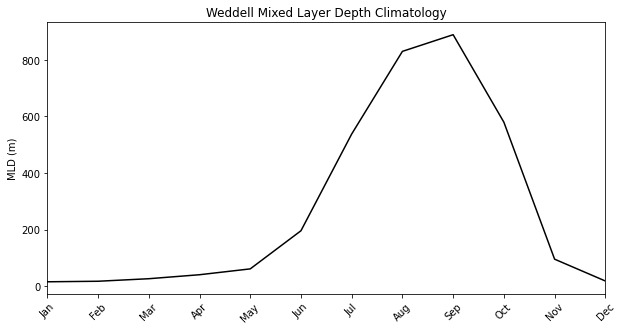

In [20]:
plot_clim('mld', 'so', so_reg='Weddell');

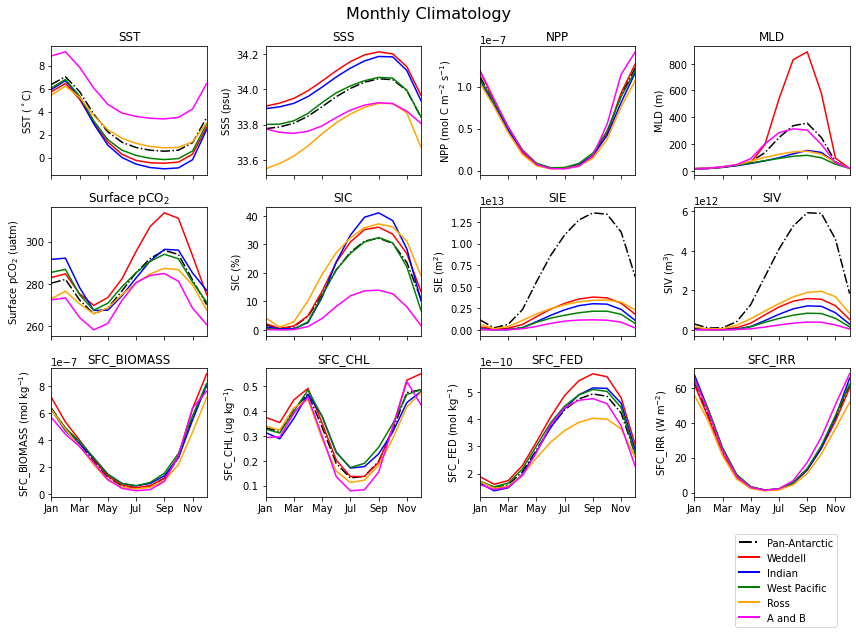

In [25]:
plot_grid_clim()

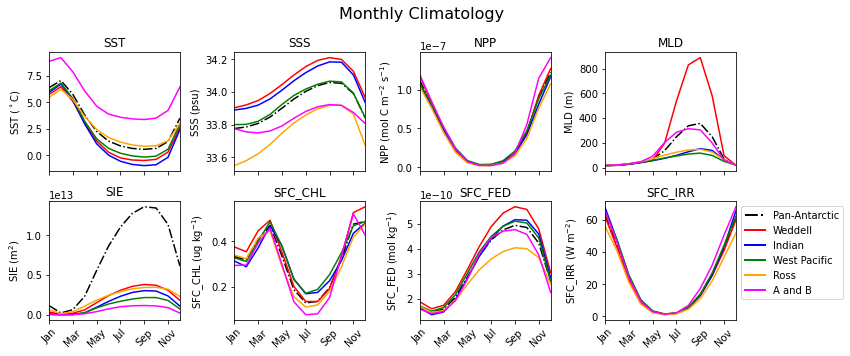

In [26]:
variables=['sst', 'sss', 'npp', 'mld', 'sie', 'sfc_chl', 'sfc_fed', 'sfc_irr']

plot_grid_clim(variables=variables, figsize=(12,5), bbox_to_anchor=(1,1))

## Monthly Std Dev

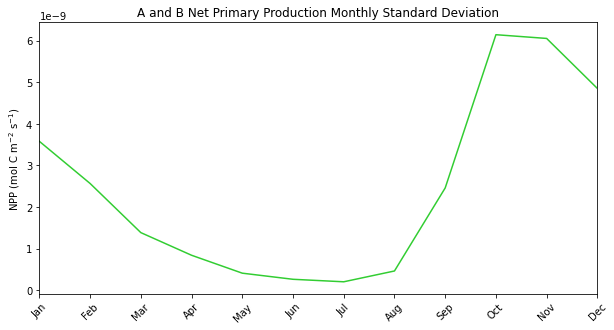

In [31]:
plot_std('npp', 'so', 'AmundBell');

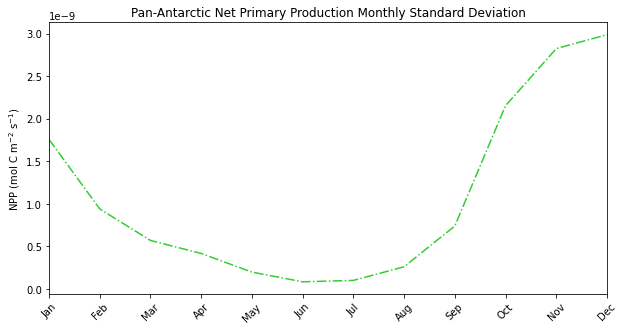

In [32]:
plot_std('npp', 'so', 'SouthernOcean');

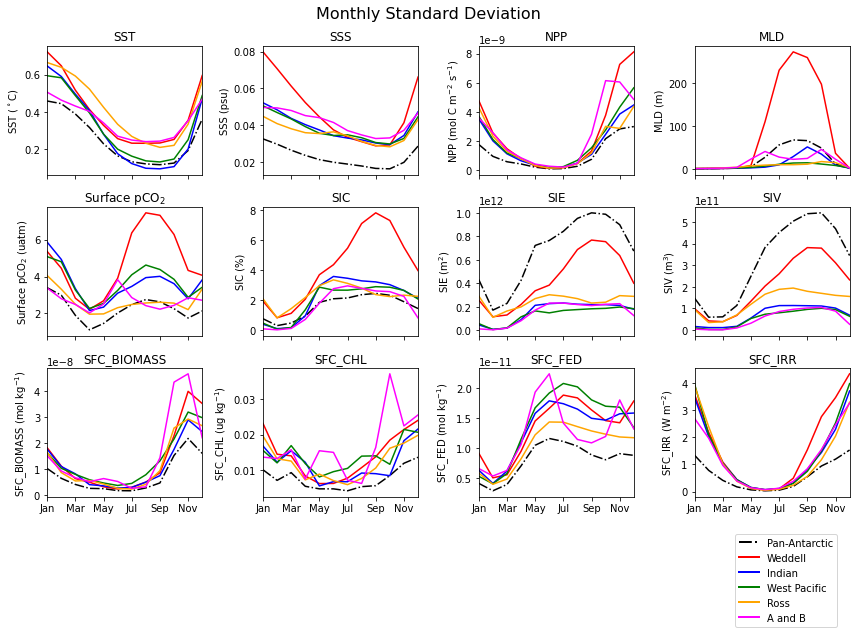

In [34]:
plot_grid_std()

## PPP (10-year lead)

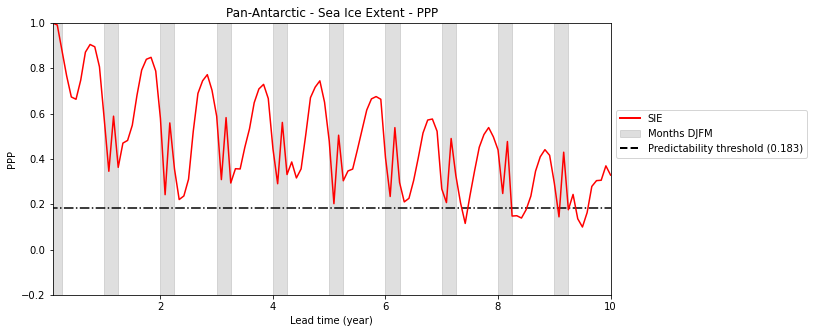

In [94]:
plot_ppp('sie', 'SouthernOcean');

In [ ]:
ppp_var_grid(['SouthernOcean', 'Weddell']);

In [ ]:
ppp_reg_grid(['mld', 'sie']);

In [ ]:
ppp_reg_grid(['npp', 'sfc_biomass']);

In [ ]:
# variables = ['sst', 'sss', 'pco2surf', 'npp', 'mld', 'sie', 'cn_inv', 'siv', 'sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr']
variables = ['mld', 'sie', 'npp', 'sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr']
# variables = ['npp', 'mld', 'sie', 'sfc_irr']
# variables = ['sst', 'sss']

ppp_grid(variables)

In [ ]:
# variables = ['sst', 'sss', 'pco2surf', 'npp', 'mld', 'sie', 'cn_inv', 'siv', 'sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr']
variables = ['mld', 'sie', 'npp', 'sfc_biomass', 'sfc_chl', 'sfc_fed', 'sfc_irr']
# variables = ['npp', 'mld', 'sie', 'sfc_irr']
# variables = ['sst', 'sss']

ppp_grid(variables, first_2yrs=True, summer_span=True)

## PPP Seasonal Cycle

In [ ]:
plot_ppp_szncycle(['npp', 'mld', 'sie', 'sfc_irr', 'sfc_biomass', 'sfc_chl', 'sfc_fed'], 'so', so_reg='AmundBell', threshold=0.183);

In [ ]:
plot_grid_ppp_szncycle(figsize=(14,8), threshold=None)

## PPP (2-year lead)

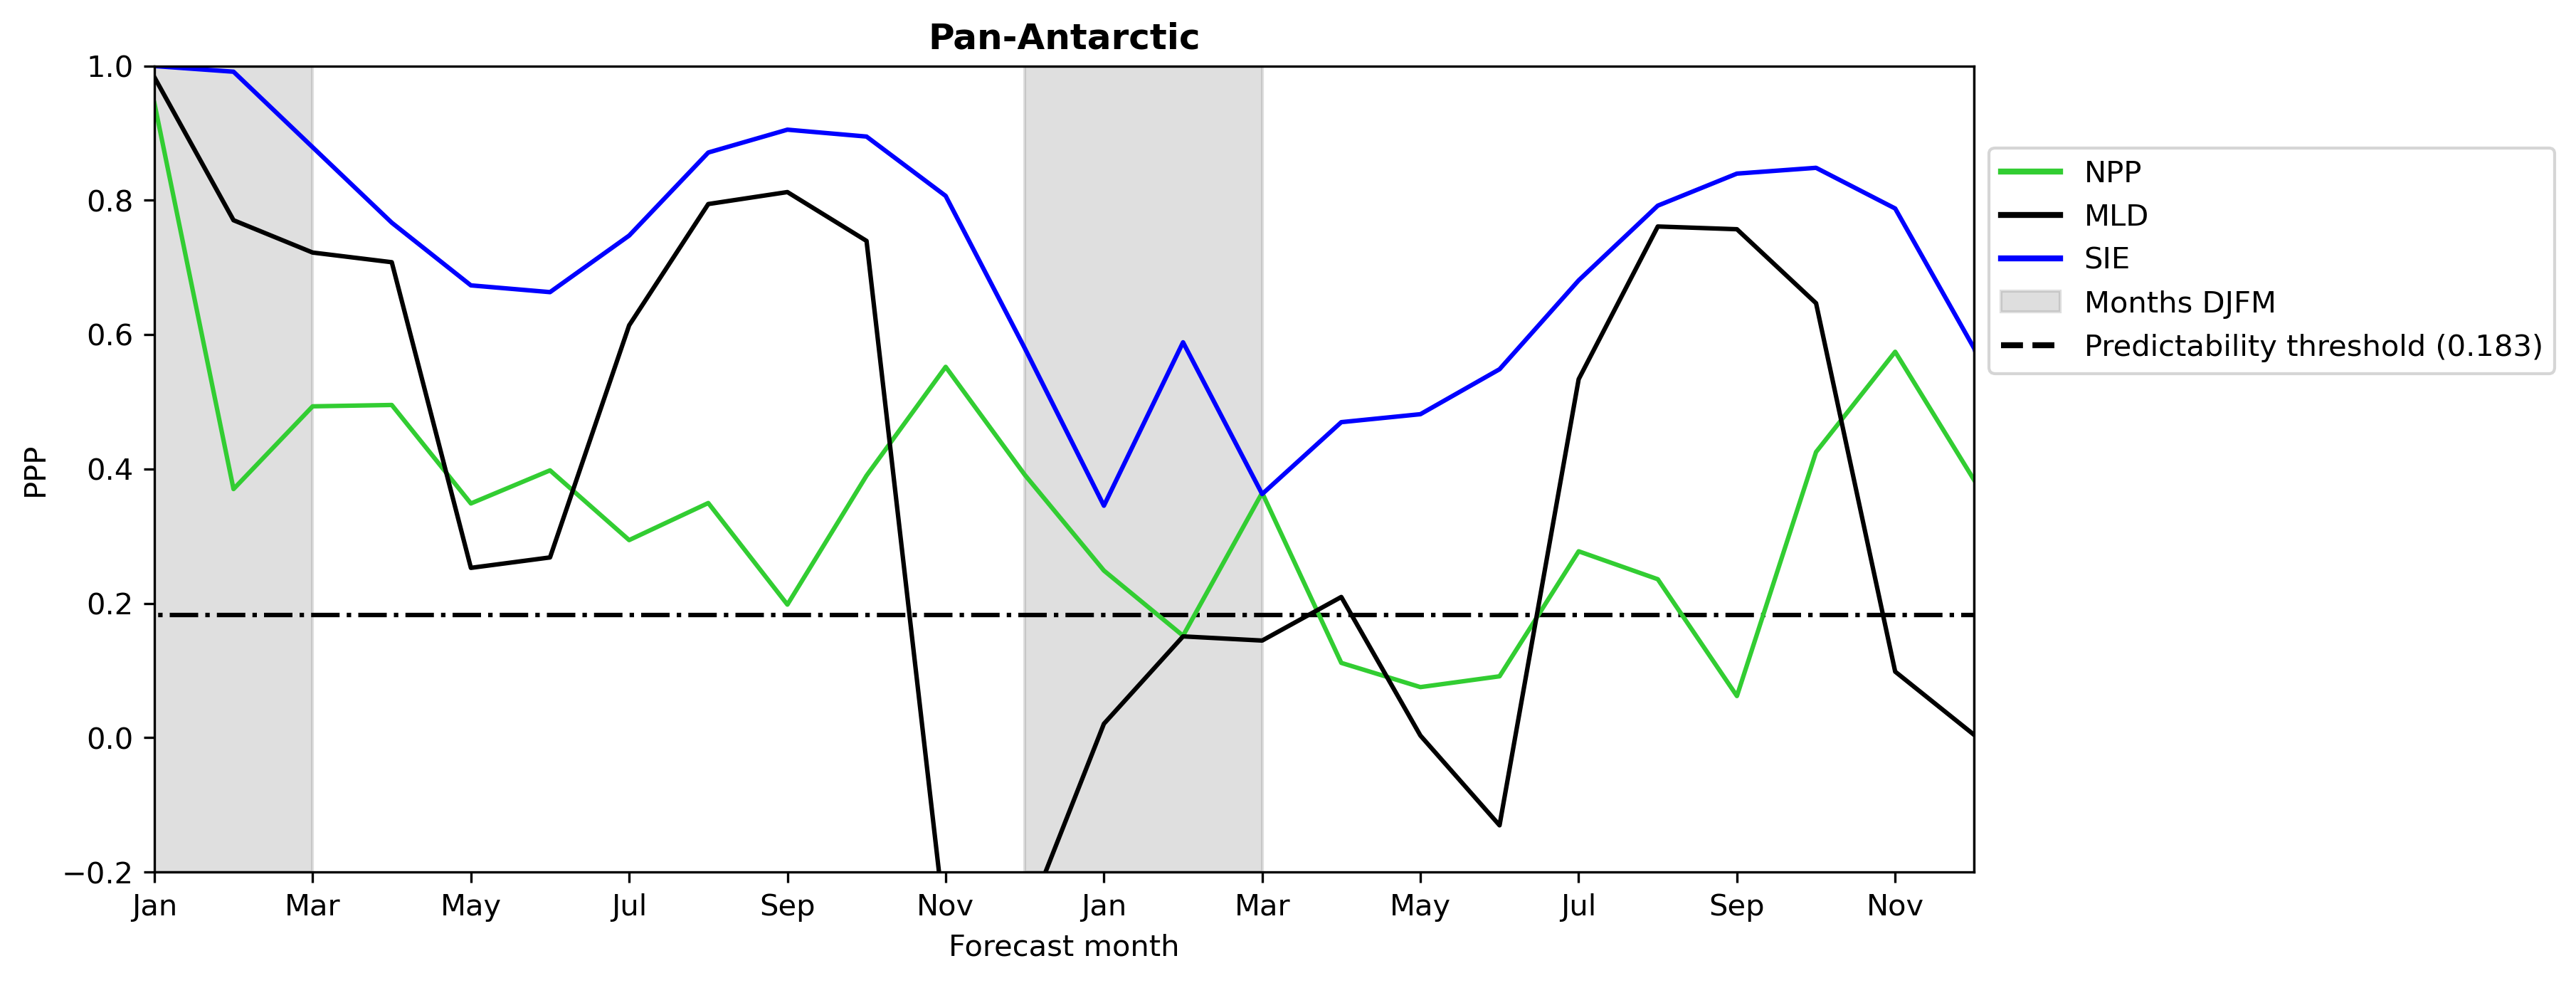

In [46]:
fig,ax = plot_ppp(['npp', 'mld', 'sie'], 'SouthernOcean', threshold=0.183, first_2yrs=True, figsize=(11,5), bbox_to_anchor=(1,0.6))

In [ ]:
regions = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']

fig,ax = plot_ppp('npp', regions, threshold=0, first_2yrs=True, bbox_to_anchor=(1,0.5))

## Heatmap Plot

`thermal, haline, ice, dense, matter, amp, deep`

In [63]:
def ppp_simple_heatmap(
    var, reg, vmin=-0.2, threshold=0.183, hatch='//', cmap=cmo.matter, figsize=(12,8)):

    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()

    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']

    if reg.lower() == 'all':
        ppp = open_ppp(var, 'so')
#         regions = ppp.data_vars
        regions = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']
        
        fig,ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=figsize)

        for (ireg,reg) in zip(range(len(regions)), regions):
            ppp_matrix = np.zeros((10,12))

            for m in range(ppp['nT'].size):
                ppp_matrix[int(m/12),m%12] = ppp[reg][m]

            ppp_matrix = ppp_matrix.T

            im = ax[int(ireg/3),ireg%3].pcolormesh(ppp_matrix, vmin=vmin, vmax=1.0, cmap=cmap, shading='auto')

            ax[int(ireg/3),ireg%3].set_title(reg_names[reg], fontweight='bold')

            ax[int(ireg/3),ireg%3].set_yticks(np.arange(ppp_matrix.shape[0]) + 0.5)
            ax[int(ireg/3),ireg%3].set_yticklabels(abbrv_month_names)

            ax[int(ireg/3),ireg%3].set_xticks(np.arange(ppp_matrix.shape[1]) + 0.5)
            ax[int(ireg/3),ireg%3].set_xticklabels(np.arange(1,11,1))
            ax[int(ireg/3),ireg%3].set_aspect('auto')

            if int(ireg/3) == 1:
                ax[int(ireg/3),ireg%3].set_xlabel('Year')

            if hatch:
                masked = np.ma.masked_array(ppp_matrix, mask=np.where(ppp_matrix > threshold, 0, 1))
                masked_im = ax[int(ireg/3),ireg%3].pcolor(masked, hatch=hatch, alpha=0)

        fig.suptitle(var_lu_names[var], fontsize=16)
        fig.tight_layout()

        cb = fig.colorbar(im, ax=ax.ravel().tolist())
        cb.ax.plot([-0.1,1.1], [threshold,threshold], color='k', linewidth=4)
        cb.ax.plot([-0.1,1.1], [0.183,0.183], color='k', ls='-.', linewidth=1)
        cb.ax.fill_between([-0.1,1.1], [1.0,1.0], [threshold,threshold], hatch=hatch, alpha=0)
        cb.ax.text(1.3, threshold-0.015, str(threshold))
        
        cb.ax.text(0.5, vmin-0.05, 'No skill', ha='center', fontsize='large')
        cb.ax.text(0.5, 1.0+0.03, 'Perfect skill', ha='center', fontsize='large')
        
        return fig,ax
    
    ## single plot
    if reg.lower() == 'global':
        ppp = open_ppp(var, 'global')
        reg = 'Global'

    if reg.lower() != 'global' and reg.lower() != 'all':
        ppp = open_ppp(var, 'so')
    
    fig,ax = plt.subplots(sharex=True, sharey=True, figsize=figsize)
    
    ppp_matrix = np.zeros((10,12))

    for m in range(ppp['nT'].size):
        ppp_matrix[int(m/12),m%12] = ppp[reg][m]
        
    ppp_matrix = ppp_matrix.T
    
    im = ax.pcolormesh(ppp_matrix, vmin=vmin, vmax=1.0, cmap=cmap, shading='auto')

    ax.set_yticks(np.arange(ppp_matrix.shape[0]) + 0.5)
    ax.set_yticklabels(abbrv_month_names)
    
    ax.set_xticks(np.arange(ppp_matrix.shape[1]) + 0.5)
    ax.set_xticklabels(np.arange(1,11,1))
    ax.set_xlabel('Year')

    cb = fig.colorbar(im, label='PPP', ax=ax)
    
    if hatch:
        masked = np.ma.masked_array(ppp_matrix, mask=np.where(ppp_matrix > threshold, 0, 1))
        masked_im = ax.pcolor(masked, hatch=hatch, alpha=0)
        cb.ax.plot([-0.1,1], [threshold,threshold], color='k')
        print('hatch threshold = '+str(threshold))
    
    fig.suptitle(reg_names[reg]+' - '+var_lu_names[var])
    fig.tight_layout()
    
    return fig,ax
    

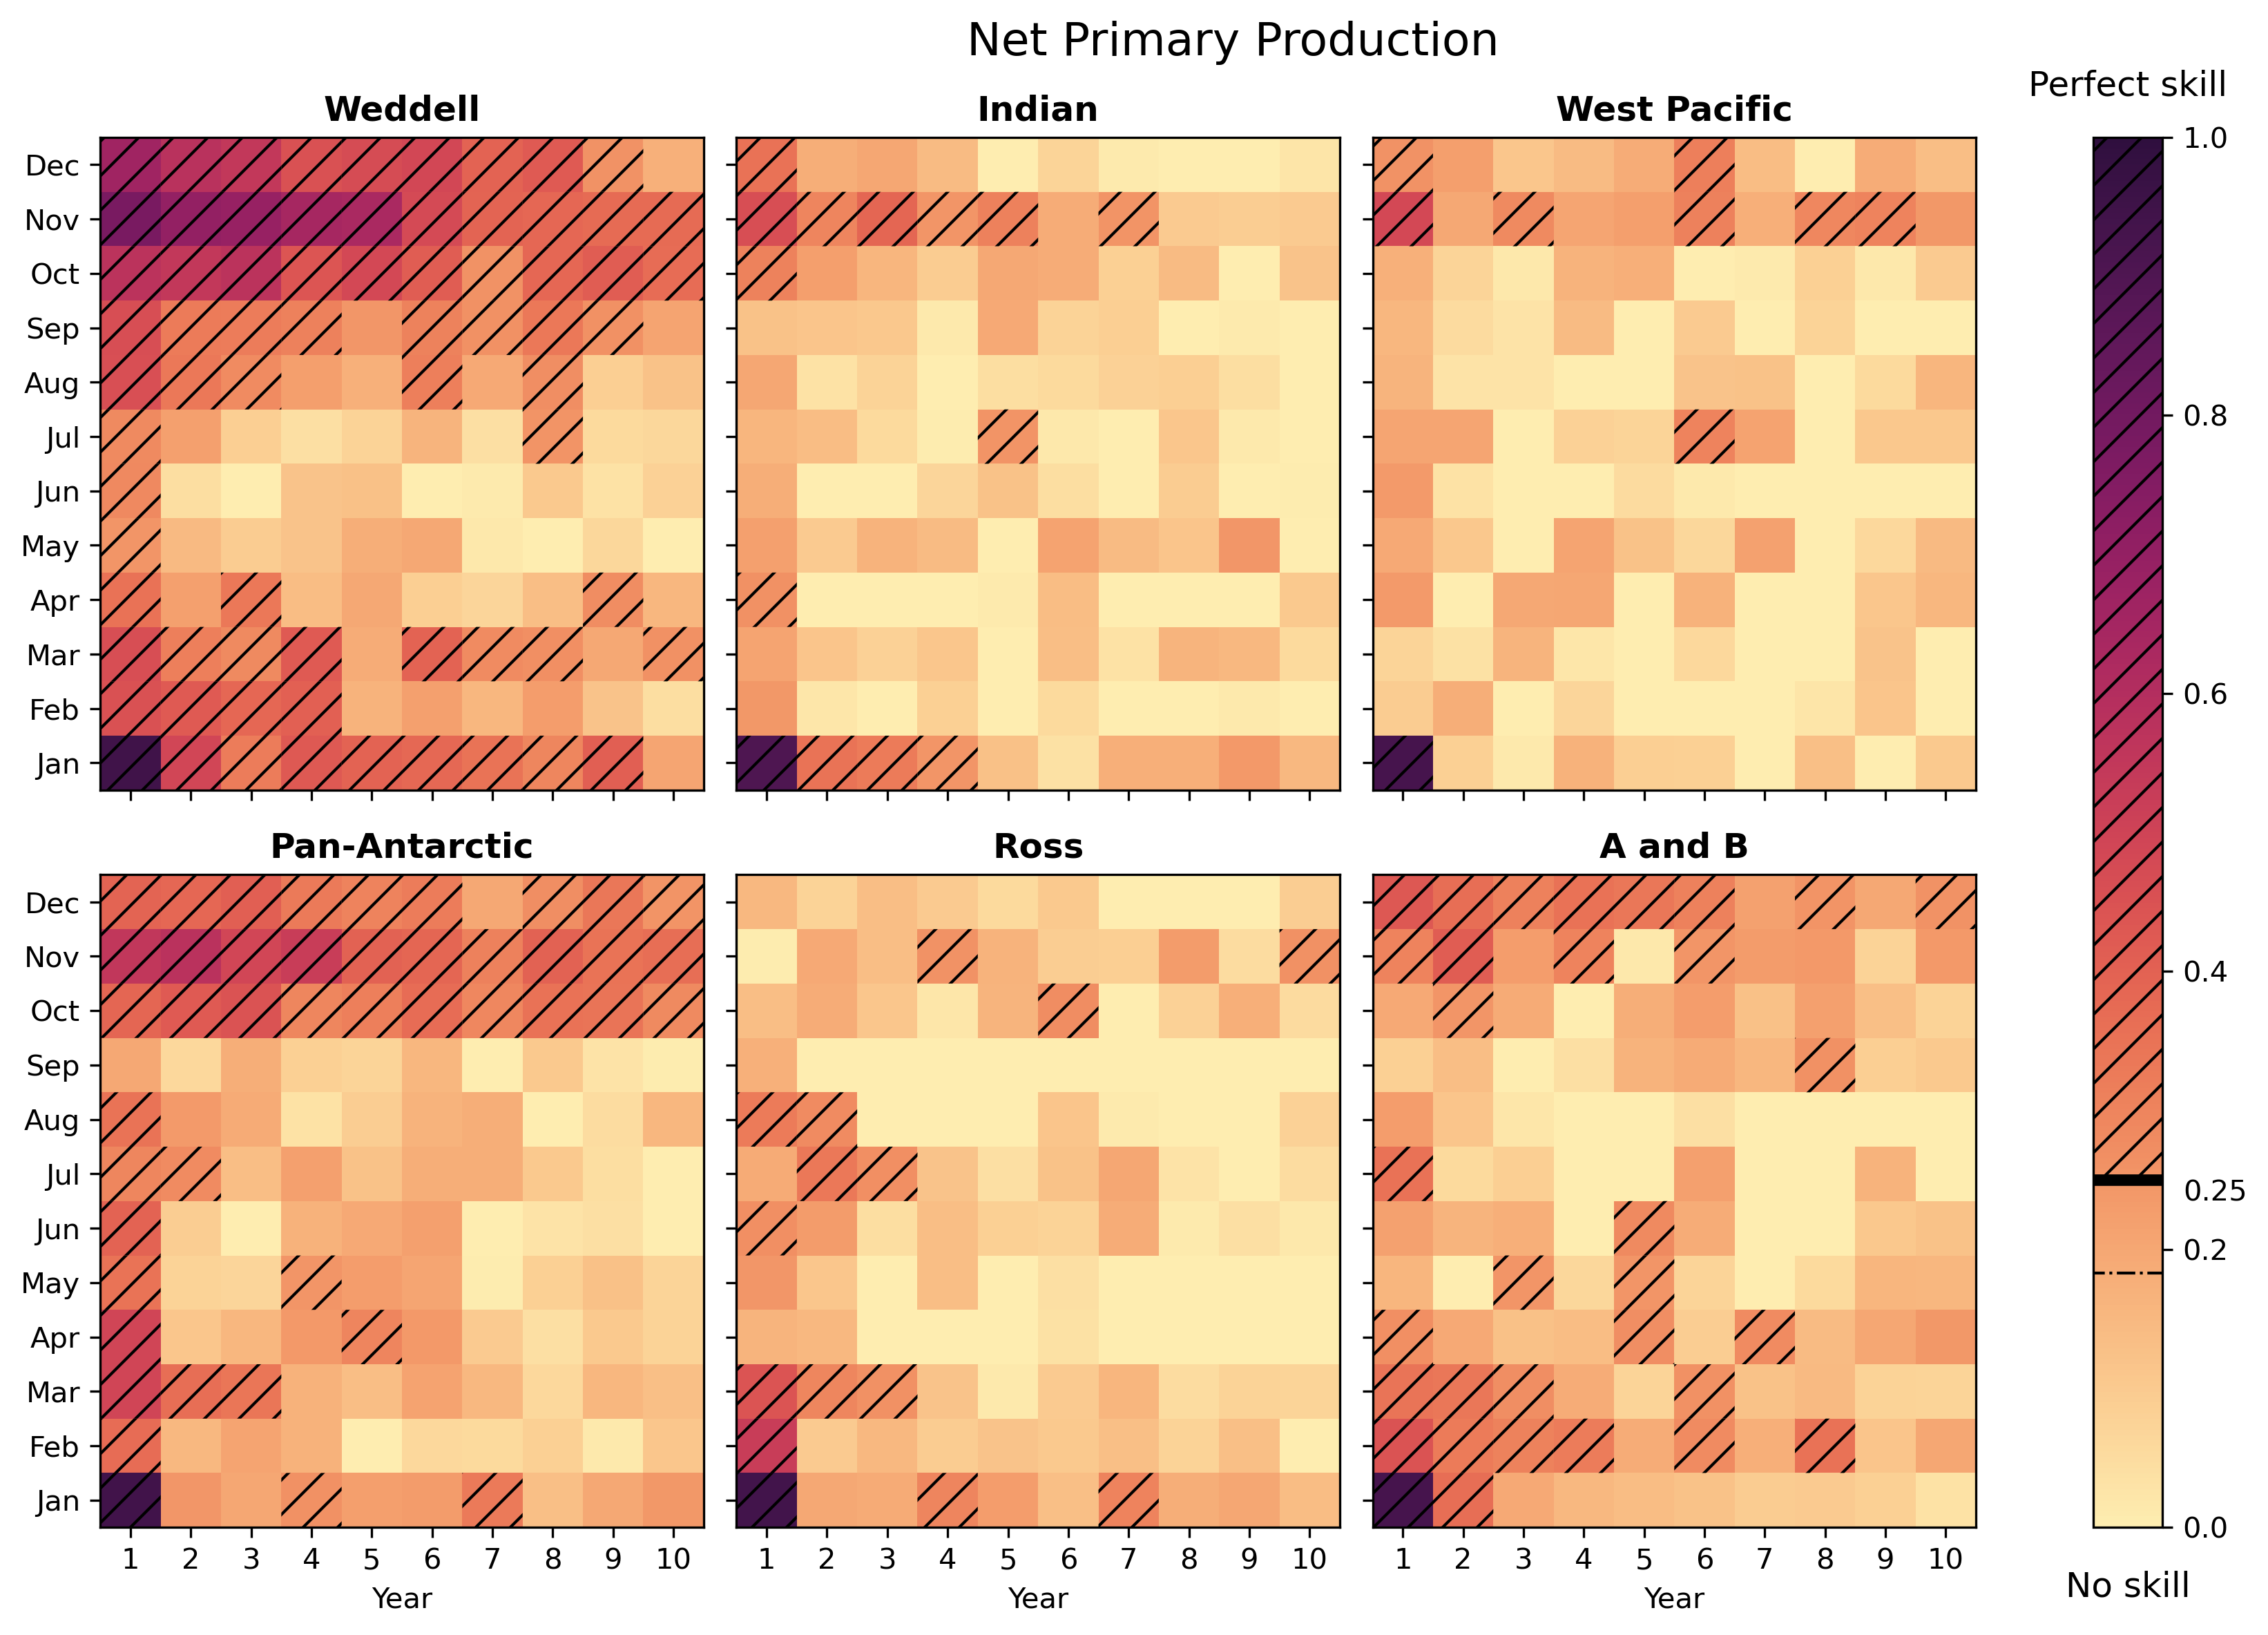

In [68]:
ppp_simple_heatmap('npp', 'all', threshold=0.25, vmin=0);

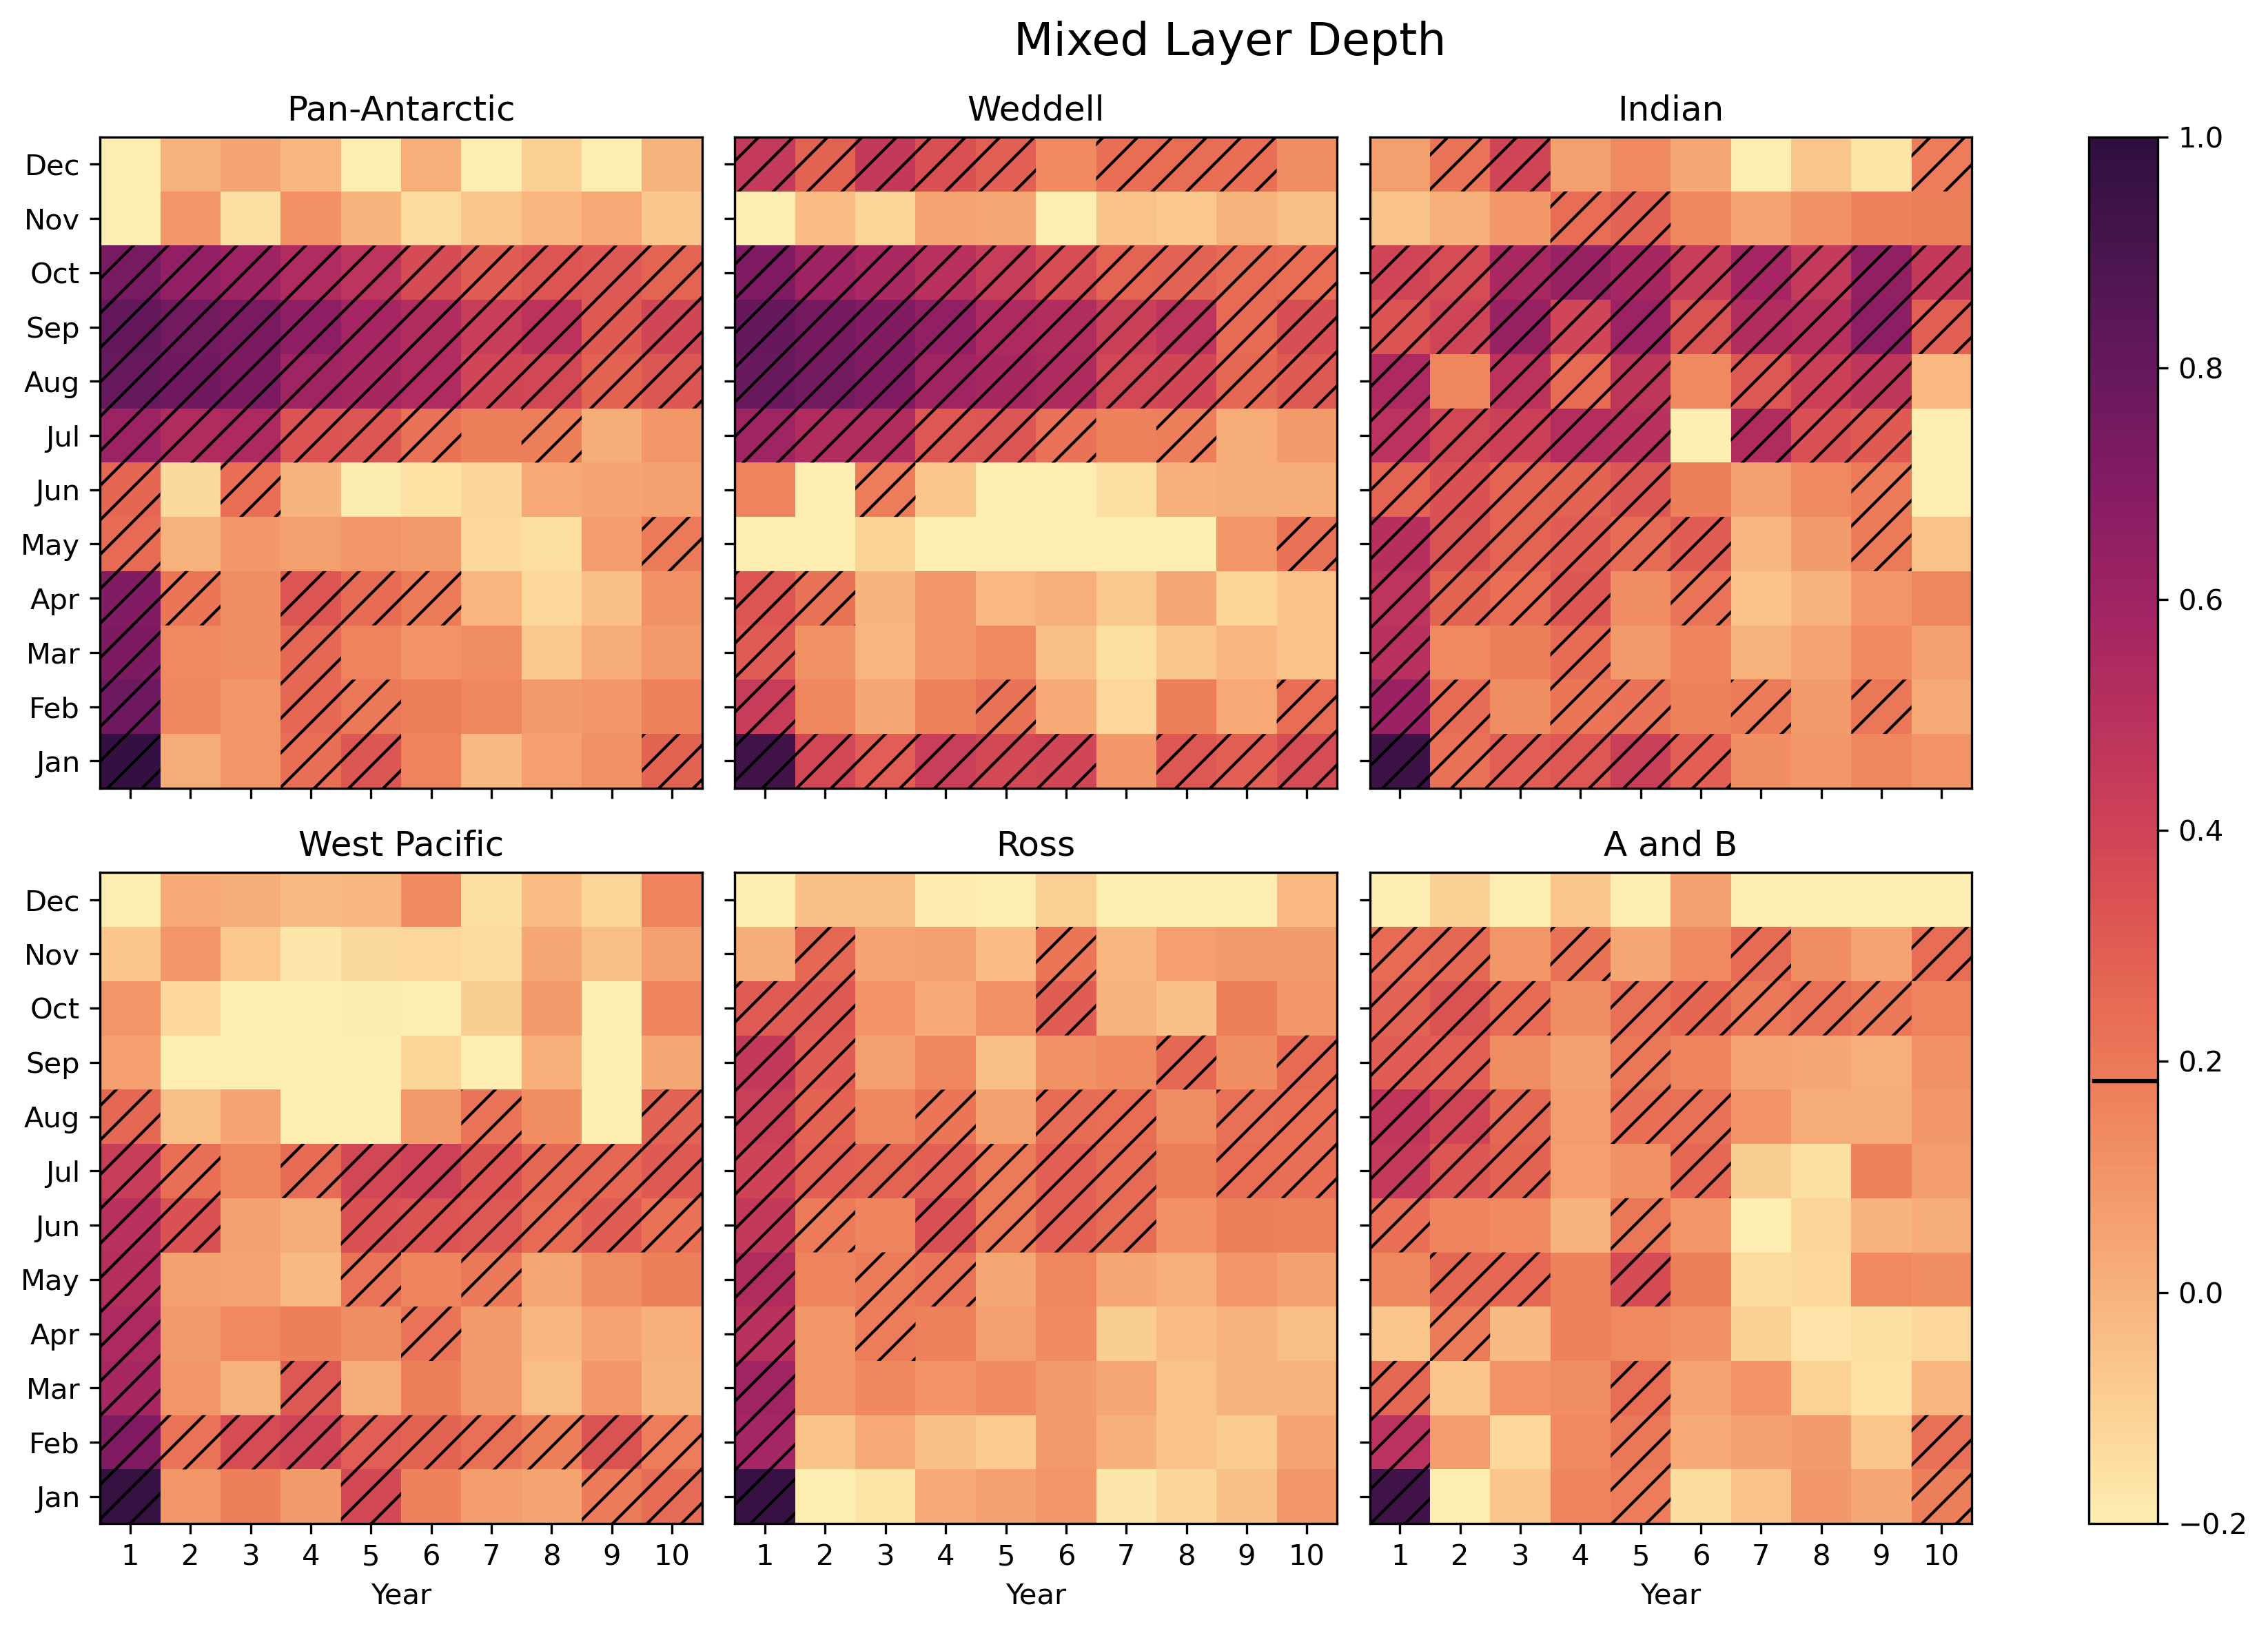

In [49]:
ppp_simple_heatmap('mld', 'all');

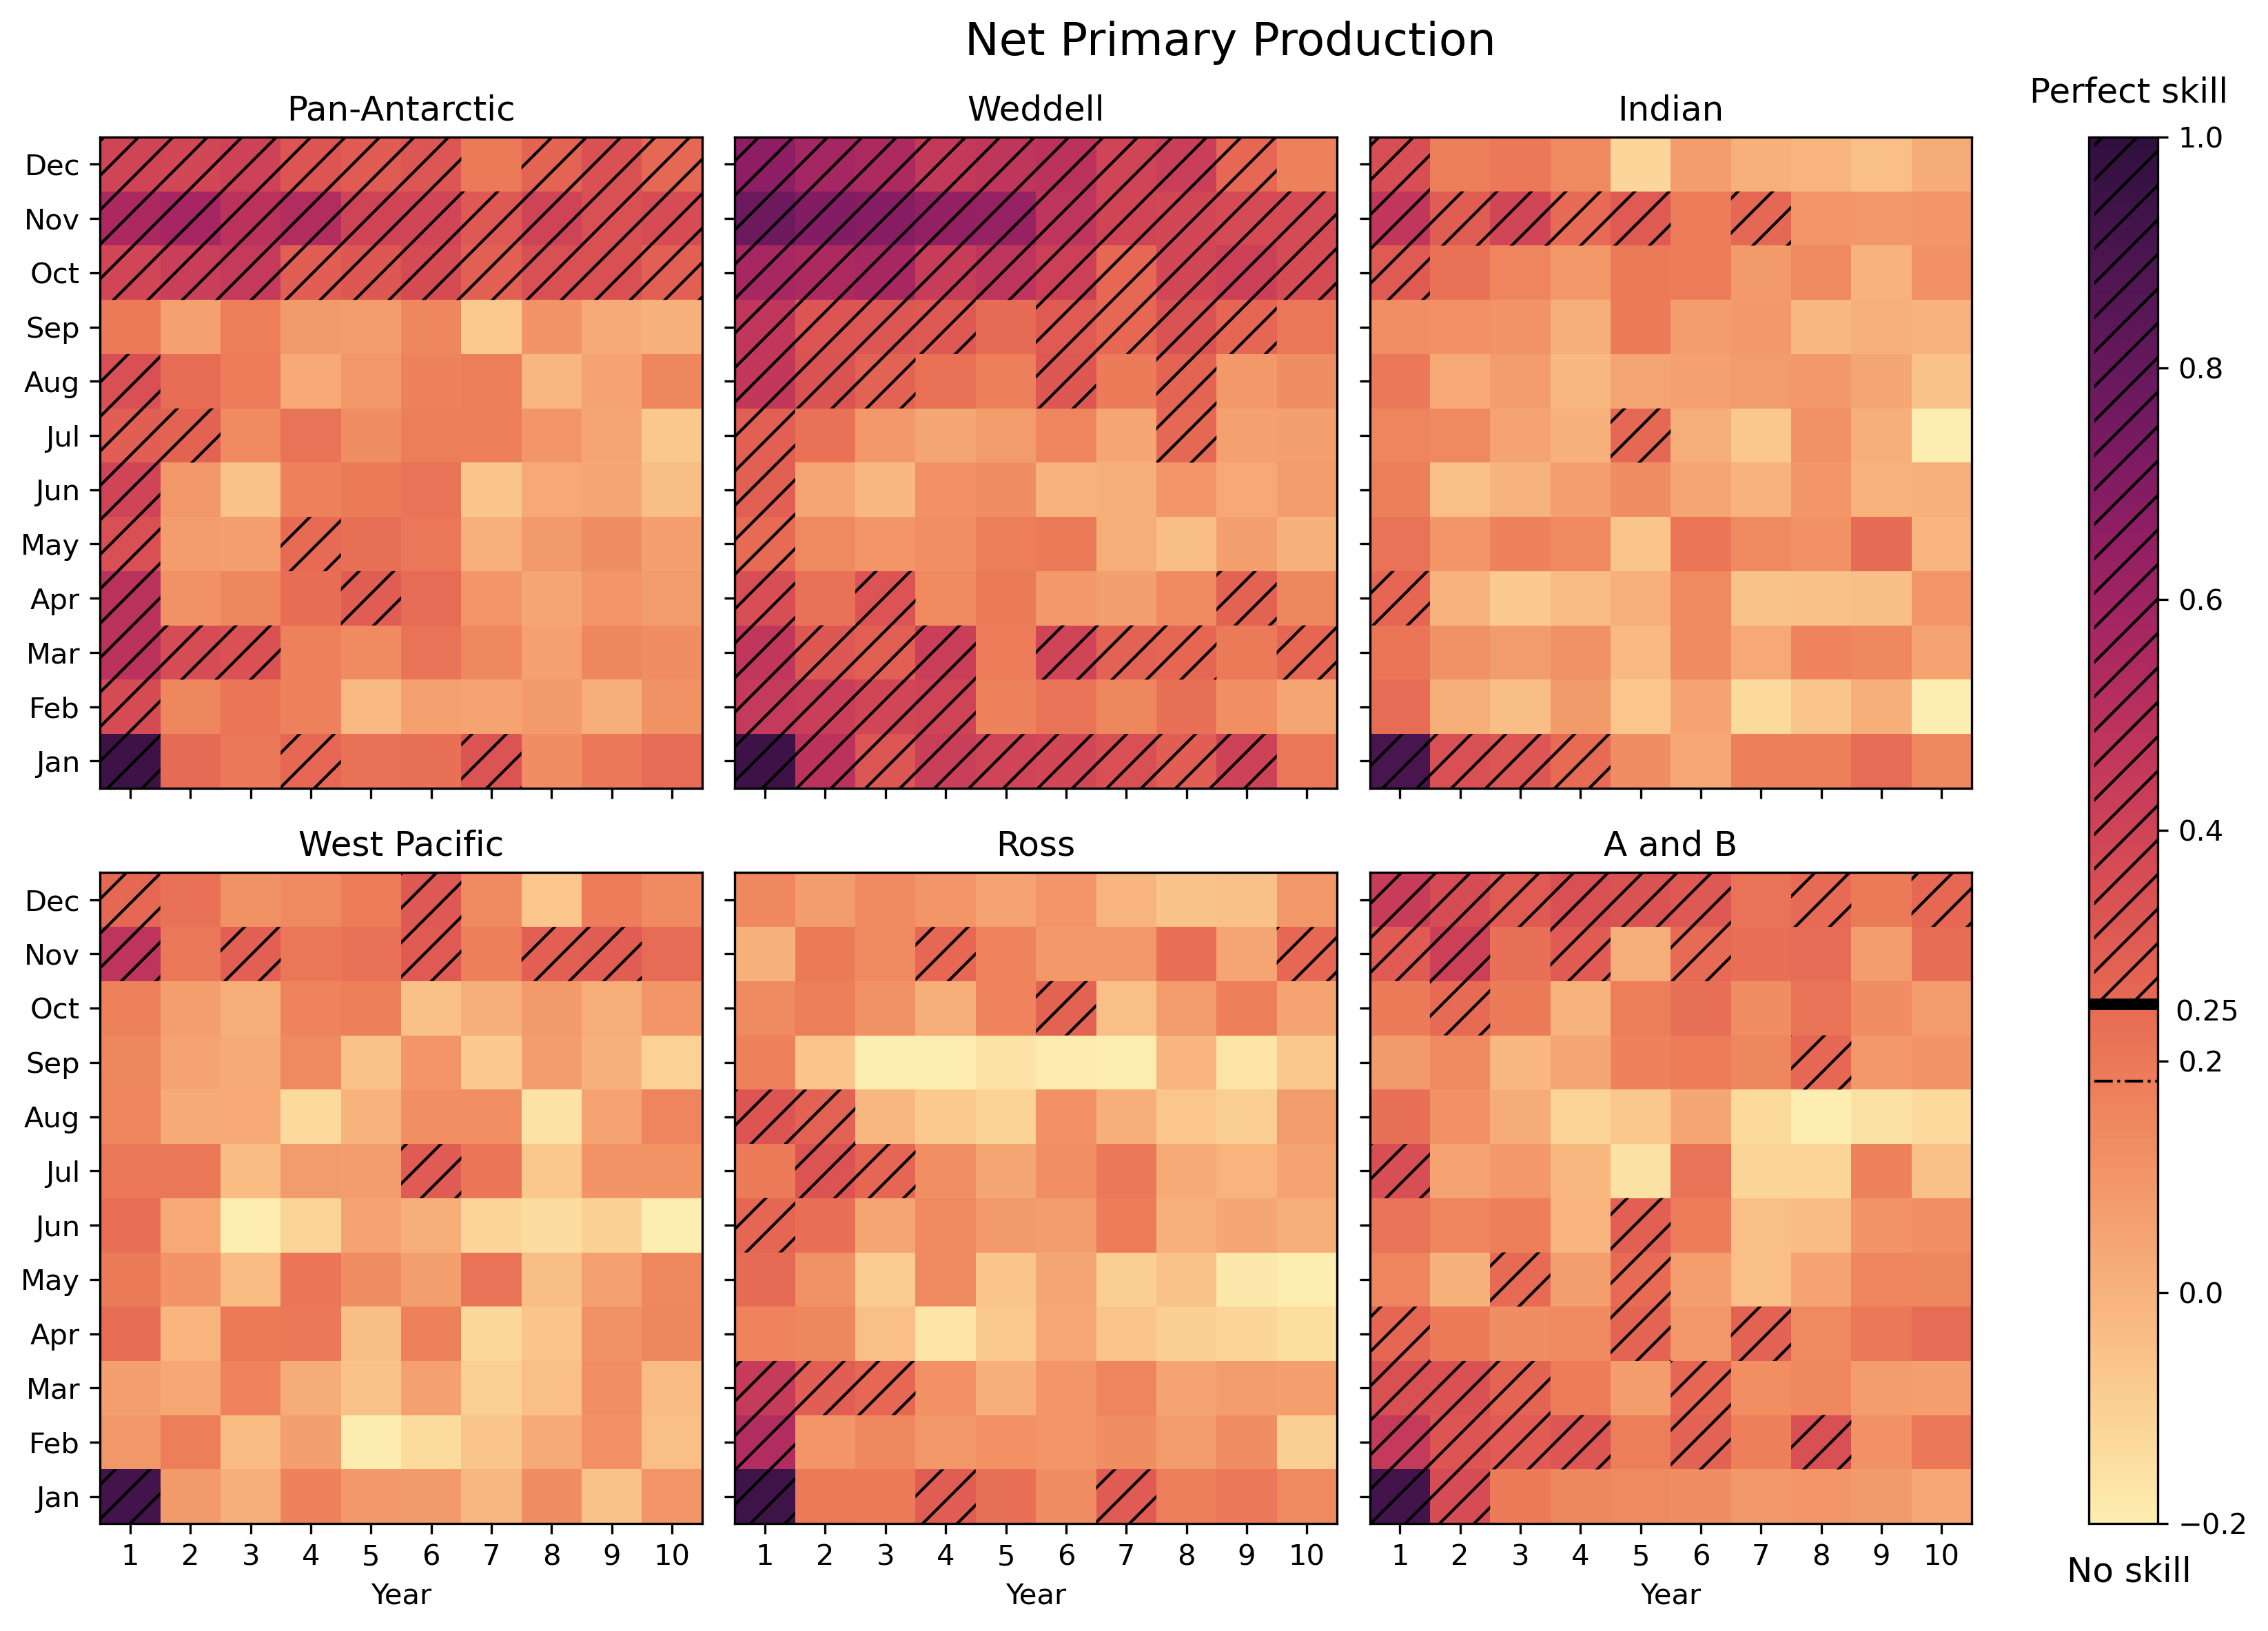

In [60]:
ppp_simple_heatmap('npp', 'all', threshold=0.25);

hatch threshold = 0.183


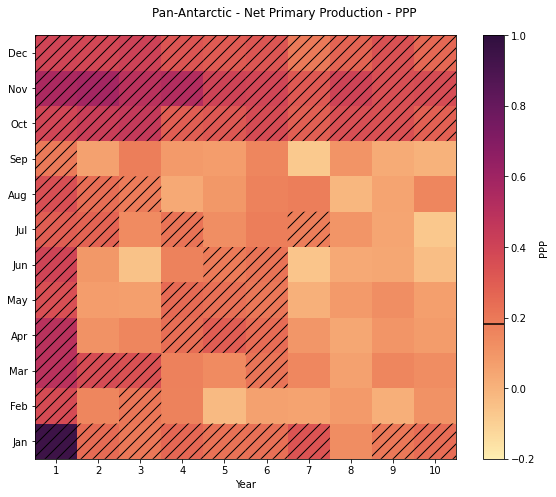

In [8]:
ppp_simple_heatmap('npp', 'SouthernOcean', hatch='//', figsize=(8,7));

hatch threshold = 0.183


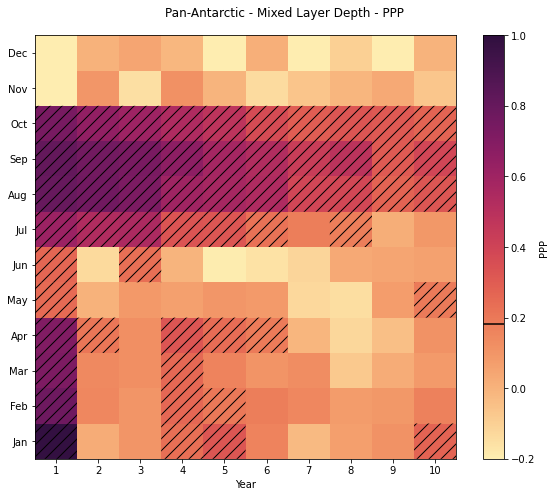

In [30]:
ppp_simple_heatmap('mld', 'SouthernOcean', hatch='//', figsize=(8,7));

hatch threshold = 0.183


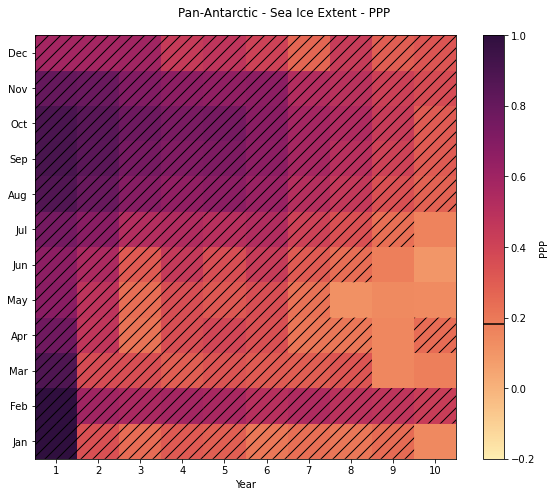

In [31]:
ppp_simple_heatmap('sie', 'SouthernOcean', hatch='//', figsize=(8,7));

In [31]:
def ppp_var_heatmap(
    variables, reg, num_months=24, vmin=-0.2, threshold=0.183, hatch='//', yaxis_steps=2, cmap=cmo.matter, figsize=(8,7)):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()

    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']

#     regions = ['SouthernOcean', 'Weddell', 'Indian', 'WestPacific', 'Ross', 'AmundBell']
    regions = ['Weddell', 'Indian', 'WestPacific', 'SouthernOcean', 'Ross', 'AmundBell']

    variable_names = []
    
    if reg.lower() == 'all':
        
        fig,ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=figsize)

        for (ireg,reg) in zip(range(len(regions)), regions):
            ppp_matrix = np.zeros((len(variables),num_months))

            for (i,var) in zip(range(len(variables)), variables):
                ppp = open_ppp(var, 'so')
                ppp_matrix[i] = ppp[reg][0:num_months]
                if ireg == 0:
                    variable_names.append(var_su_names[var])

            ppp_matrix = ppp_matrix.T

            im = ax[int(ireg/3),ireg%3].pcolormesh(ppp_matrix, vmin=vmin, vmax=1.0, cmap=cmap, shading='auto')

            ax[int(ireg/3),ireg%3].set_yticks(np.arange(0,ppp_matrix.shape[0],yaxis_steps) + 0.5)
            mult = int(num_months/12)+1
            ylabels = (abbrv_month_names*mult)[0:num_months:yaxis_steps]
            
            for (i,yr) in zip(range(len(ylabels)), range(0,num_months,yaxis_steps)):
                if ylabels[i] == 'Jan':
#                     ylabels[i] = ylabels[i] + ' ' + str(yr//12 + 1)
                    ylabels[i] = str(yr//12 + 1)+'   '+ylabels[i]
                
            ax[int(ireg/3),ireg%3].set_yticklabels(ylabels)
            
            if ireg%3 == 0:
                ax[int(ireg/3),ireg%3].set_ylabel('Forecast month')

            ax[int(ireg/3),ireg%3].set_xticks(np.arange(ppp_matrix.shape[1]) + 0.5)
            ax[int(ireg/3),ireg%3].set_xticklabels(variable_names)
            plt.setp(ax[int(ireg/3),ireg%3].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            
            ax[int(ireg/3),ireg%3].set_title(reg_names[reg], fontsize='x-large', fontweight='bold')
    
            if hatch:
                masked = np.ma.masked_array(ppp_matrix, mask=np.where(ppp_matrix > threshold, 0, 1))
                masked_im = ax[int(ireg/3),ireg%3].pcolor(masked, hatch=hatch, alpha=0)

        fig.tight_layout()

        cb = fig.colorbar(im, ax=ax.ravel().tolist())
        cb.ax.plot([-0.1,1.1], [threshold,threshold], color='k', linewidth=4)
        cb.ax.plot([-0.1,1.1], [0.183,0.183], color='k', ls='-.', linewidth=1)
        cb.ax.fill_between([-0.1,1.1], [1.0,1.0], [threshold,threshold], hatch=hatch, alpha=0)
        cb.ax.text(1.3, threshold-0.015, str(threshold))
        
        cb.ax.text(0.5, vmin-0.05, 'No skill', ha='center', fontsize='large')
        cb.ax.text(0.5, 1.0+0.03, 'Perfect skill', ha='center', fontsize='large')

        return fig,ax
            
    ## single plots
    if reg.lower() == 'global':
        subreg = 'global'
        reg = 'Global'

    if reg.lower() != 'global' and reg.lower() != 'all':
        subreg = 'so'

    ppp_matrix = np.zeros((len(variables),num_months))

    for (i,var) in zip(range(len(variables)), variables):
        ppp = open_ppp(var, subreg)
        ppp_matrix[i] = ppp[reg][0:num_months]
        variable_names.append(var_su_names[var])

    ppp_matrix = ppp_matrix.T

    fig,ax = plt.subplots(figsize=figsize)

    im = ax.pcolormesh(ppp_matrix, vmin=vmin, vmax=1.0, cmap=cmap, shading='auto')
    
    ax.set_yticks(np.arange(0,ppp_matrix.shape[0],yaxis_steps) + 0.5)
    mult = int(num_months/12)+1
    ax.set_yticklabels((abbrv_month_names*mult)[0:num_months:yaxis_steps])
    ax.set_ylabel('Forecast month')
    
    ax.set_xticks(np.arange(ppp_matrix.shape[1]) + 0.5)
    ax.set_xticklabels(variable_names)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    cb = fig.colorbar(im, label='PPP')
    
    if hatch:
        masked = np.ma.masked_array(ppp_matrix, mask=np.where(ppp_matrix > threshold, 0, 1))
        masked_im = ax.pcolor(masked, hatch=hatch, alpha=0)
        cb.ax.plot([-0.1,1], [threshold,threshold], color='k', linewidth=4)
        
        cb.ax.text(1.45, threshold, 'Hatch threshold ('+str(threshold)+')')
        
        cb.ax.text(0.5, vmin-0.05, 'No skill', ha='center')
        cb.ax.text(0.5, 1.0+0.03, 'Perfect skill', ha='center')

    fig.suptitle(reg_names[reg]+' - PPP', fontsize=16)
    fig.tight_layout()
    
    return fig,ax

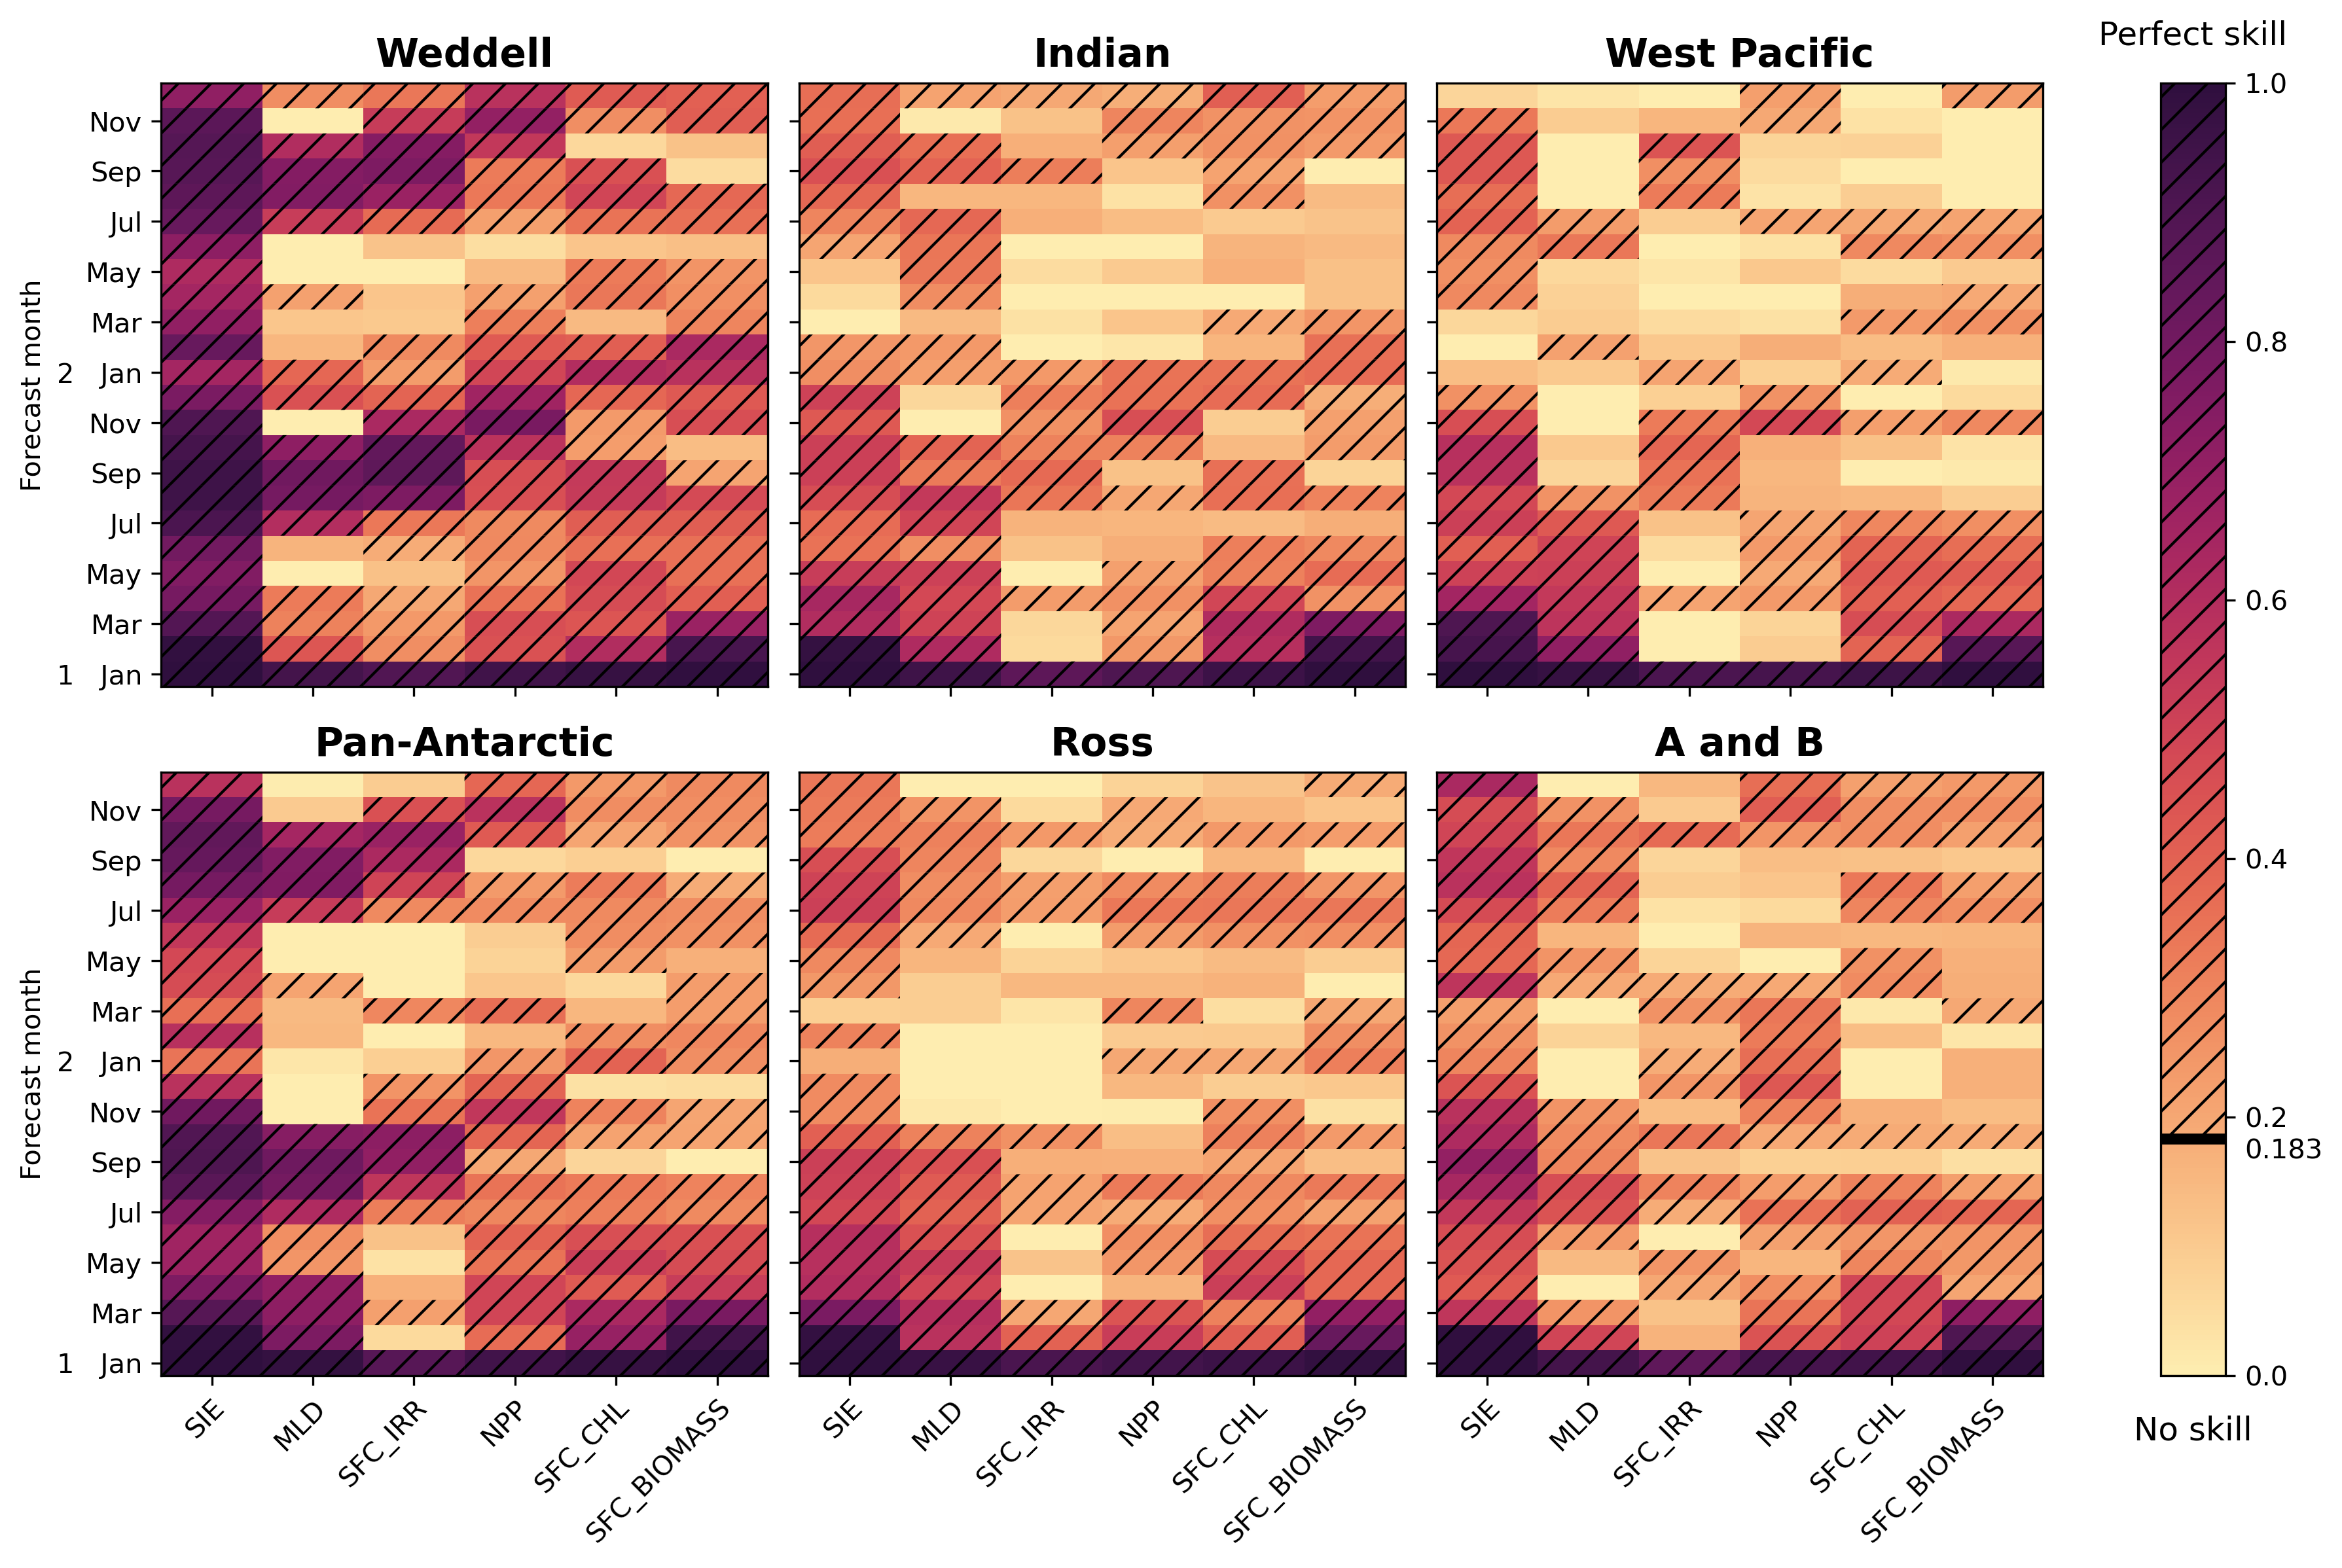

In [32]:
variables = ['sie', 'mld', 'sfc_irr', 'npp', 'sfc_chl', 'sfc_biomass']

ppp_var_heatmap(variables, 'all', num_months=24, figsize=(13,8), vmin=0, threshold=0.183);